In [1]:
import numpy as np
import scipy as scipy
import sys
import copy
import myfun as mf
import pickle as pkl

from scipy.spatial import distance as sc_dist

import matplotlib
from matplotlib import gridspec, rc, colors
from matplotlib.ticker import LogLocator, LogFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture as GMM

rc('text',usetex=True)#, latex.preamble = r'\usepackage{{amsmath}}')
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'

#rc('text.latex', preamble='\usepackage{color}')


from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import json

In [2]:
headdir    = '/Users/simonfreedman/cqub/bifurc/paper_figs/' #'.' #'/Users/simonfreedman/cqub/bifurc/weinreb_2020/'
figdir     = '{0}/figs'.format(headdir)
datdir     = '{0}/neutrophil_data'.format(headdir)
eigdir     = '{0}/eig'.format(datdir)
pst_fname  = '{0}/pseudotime.txt'.format(datdir)


In [3]:
pst_eig1     = np.load('{0}/dat_eval.npy'.format(eigdir))[:,0]
pst_pc1      = np.load('{0}/dat_evec.npy'.format(eigdir))[:,0]
mu_gexp      = np.load('{0}/high_var_gexp_trajs.npy'.format(datdir))
pc1_proj     = np.load('{0}/gexp_pc1_proj.npy'.format(datdir))
neut_psts    = np.genfromtxt(pst_fname, skip_header=True, dtype='int')


with open('{0}/bin_cidxs.pkl'.format(eigdir),'rb') as f:
    bin_cidxs = pkl.load(f)

In [4]:
# COMPUTE THE PROJECTIONS HERE...
# print('loading gene expression matrix')
# gexp_fname = '{0}/gene_expr.npz'.format(datdir)
# gexp_sp    = scipy.sparse.load_npz(gexp_fname) # WT: 18.3 seconds
# pc1_proj = gexp_sp.dot(pst_pc1.T)
# np.save('{0}/gexp_pc1_proj.npy'.format(datdir),pc1_proj)

In [5]:
gnm_fname  = '{0}/gene_names.txt'.format(datdir)
gnms     = np.genfromtxt(gnm_fname,dtype='str')

In [6]:
pc1_corr = pst_pc1.dot(pst_pc1.T)

In [7]:
gexp_norm = np.linalg.norm(mu_gexp,axis=1)
gexp_norm_outer = np.outer(gexp_norm, gexp_norm)
mu_gexp_cc = mu_gexp.dot(mu_gexp.T)/gexp_norm_outer

In [8]:

#cols = plt.cm.viridis(np.linspace(dens_min, dens_max, 100))
#cols(dens2)
def dens_norm(dens, eps=1e-12):
    dens2 = np.log10(dens,where=dens>1e-12,out=np.zeros_like(dens))
    dens_min, dens_max = np.amin(dens2[dens2!=0]), np.amax(dens2[dens2!=0])
    dens3 = (dens2-dens_min)/(dens_max-dens_min)
    dens3[dens<1e-12]=-1
    return dens3

def get_bin_mesh(xbinlim, ybinlim):
    xbctr = 0.5*(xbinlim[1:]+xbinlim[:-1])
    ybctr = 0.5*(ybinlim[1:]+ybinlim[:-1])
    return np.meshgrid(xbctr, ybctr)

In [9]:
nt            = len(bin_cidxs)
nbranch       = 2
bifts         = np.array([87,109])
evec_ts       = np.hstack([[0],bifts])
split_ts      = np.hstack([evec_ts,[nt]])

dat           = pc1_proj[bin_cidxs[bifts[1]],bifts[1]].reshape(-1,1)
mygmm         = GMM(n_components=nbranch).fit(dat)
gmm_preds     = [mygmm.predict(pc1_proj[bin_cidxs[t],bifts[1]].reshape(-1,1)) for t in np.arange(nt)]
gmm_pred_idxs = [[np.where(gmm_preds[t]==i)[0] for i in range(nbranch)] for t in range(nt)]
nc1 = np.array([len(gmm_pred_idxs[t][1]) for t in range(nt)])
t0 = np.where(nc1<1000)[0][0]

traj_idxs_split        = [np.hstack([bin_cidxs[t] for t in range(split_ts[i],split_ts[i+1])]) 
                   for i in range(len(split_ts)-1)]
branch_cidxs_flat      = [np.hstack([bin_cidxs[t][gmm_pred_idxs[t][i]] for t in range(t0, nt)]) 
                     for i in range(nbranch)]
traj_idxs_split_branch = [traj_idxs_split[0]]+branch_cidxs_flat

In [10]:
nc_all = np.array(list(map(len, bin_cidxs)))

In [11]:
print('loading gene expression matrix')
gexp_fname = '{0}/gene_expr.npz'.format(datdir)
gexp_sp    = scipy.sparse.load_npz(gexp_fname) # WT: 18.3 seconds
#gexp_lil   = gexp_sp.tolil() # WT: 3 min 55 seconds
#gexp_full  = gexp_lil.toarray()
gexp_full  = gexp_sp.toarray() # WT: 3 min 55 seconds

loading gene expression matrix


In [12]:
evec_dists = sc_dist.squareform(sc_dist.pdist(pst_pc1))
evec_ts2  = [evec_ts[i]+np.argmin(np.sum(evec_dists[evec_ts[i]:evec_ts[i+1],evec_ts[i]:evec_ts[i+1]],axis=1)) for i in range(len(evec_ts)-1)]
evec_ts2 += [evec_ts[-1]]

In [13]:
# gexp_l2_norm = np.linalg.norm(gexp_full, axis=1)
# gexp_l2_normd = gexp_full.T / gexp_l2_norm
# pc1_costh = pst_pc1.dot(gexp_l2_normd)#.dot(pst_pc1.T)
# np.save('{0}/gexp_costh.npy'.format(datdir),pc1_costh)
pc1_costh = np.load('{0}/gexp_costh.npy'.format(datdir))

In [14]:
# bif_pc1 = pst_pc1[t_bifurc]
# cosths = np.zeros(len(evec_ts), nt, )

# for t in range(npsts):
# gexp_t = gexp_full[bin_cidxs[t]].toarray()
# gexp_t_norm = (gexp_t.T / np.linalg.norm(gexp_t,axis=1))
# cosths.append(pst_pc1[t].dot(gexp_t_norm))


In [15]:
#pc1_proj.shape

In [16]:
nclust = 2
gmm_cov_eval = np.array([[
    PCA(n_components=1).fit(gexp_full[bin_cidxs[t][gmm_pred_idxs[t][i]]]).explained_variance_[0] 
    if len(gmm_pred_idxs[t][i])>0 else np.nan for i in range(nclust)] for t in range(nt)]
    )

In [17]:
# npst = len(bin_cidxs)
# hmaxs = np.array([np.amax(pc1_proj[:,bift]) for bift in bifts])
# hmins = np.array([np.amin(pc1_proj[:,bift]) for bift in bifts])
# nbins = 20
# hbins = np.array([np.linspace(hmins[i], hmaxs[i]*1.001,nbins) for i in range(len(bifts))])
# sgns = np.array([-1,1])
# hbins = np.array([np.sort(hbins[i]*sgns[i]) for i in range(len(hbins))])
# bif_proj_hists  = np.array([[np.histogram(sgns[i]*pc1_proj[bin_cidxs[t],bifts[i]], bins=hbins[i])[0] 
#                             for t in range(npst)] 
#                           for i in range(len(bifts))])
# bif_proj_dens_hists = np.array([[np.histogram(sgns[i]*pc1_proj[bin_cidxs[t],bifts[i]], bins=hbins[i], 
#                                               density=True)[0] 
#                             for t in range(npst)]
#                           for i in range(len(bifts))])
# hbin_mids = 0.5*(hbins[:,1:]+hbins[:,:-1])

In [18]:
evec_ts2

[40, 97, 109]

In [19]:
# npst  = len(bin_cidxs)
# nbif  = len(bifts) 
# hmaxs = np.array([np.amax(pc1_costh[bift]) for bift in evec_ts2[1:]])
# hmins = np.array([np.amin(pc1_costh[bift]) for bift in evec_ts2[1:]])
# #nbins = 42
# #hbins = np.array([np.linspace(hmins[i], hmaxs[i]*1.001,nbins) for i in range(nbif)])
# bwidth = 0.1
# nbins = int(2./bwidth)+2
# bmax = 1+bwidth/2
# hbins = np.array([np.linspace(-bmax,bmax,nbins) for i in range(nbif)])

# sgns = np.array([-1,1])
# hbins = np.array([np.sort(hbins[i]*sgns[i]) for i in range(len(hbins))])
# bif_proj_hists  = np.array([[np.histogram(sgns[i]*pc1_costh[evec_ts2[i+1], bin_cidxs[t]], bins=hbins[i])[0] 
#                             for t in range(npst)] 
#                           for i in range(nbif)])
# bif_proj_dens_hists = np.array([[np.histogram(sgns[i]*pc1_costh[evec_ts2[i+1], bin_cidxs[t]], bins=hbins[i], 
#                                               density=True)[0] 
#                             for t in range(npst)]
#                           for i in range(nbif)])
# hbin_mids = 0.5*(hbins[:,1:]+hbins[:,:-1])

In [20]:
npst  = len(bin_cidxs)
nbif  = len(bifts) 
nevec = len(evec_ts2)
hmaxs = np.array([np.amax(pc1_costh[bift]) for bift in evec_ts2])
hmins = np.array([np.amin(pc1_costh[bift]) for bift in evec_ts2])

bwidth = 0.1
nbins = int(2./bwidth)+2
bmax = 1+bwidth/2
hbins = np.array([np.linspace(-bmax,bmax,nbins) for i in range(nevec)])

sgns  = np.array([-1,-1,1])
hbins = np.array([np.sort(hbins[i]*sgns[i]) for i in range(len(hbins))])
bif_proj_hists  = np.array([[np.histogram(sgns[i]*pc1_costh[evec_ts2[i], bin_cidxs[t]], bins=hbins[i])[0] 
                            for t in range(npst)] 
                          for i in range(nevec)])
bif_proj_dens_hists = np.array([[np.histogram(sgns[i]*pc1_costh[evec_ts2[i], bin_cidxs[t]], bins=hbins[i], 
                                              density=True)[0] 
                            for t in range(npst)]
                          for i in range(nevec)])
hbin_mids = 0.5*(hbins[:,1:]+hbins[:,:-1])

In [21]:
#np.linspace(-1.05,1.05,22)

In [22]:
fnm    = "{0}/mmu00001.json".format(datdir)
mmu_ko = json.load(open(fnm))

gnm_ko    = {}
ko_id_def = [{},{},{},{}]
ko_gid_gnm = {}
ko_gnm_gid = {}
proc_gnms = [{},{},{}]

for di in mmu_ko['children']:
    id1,def1          = di['name'].split(' ',1)
    id1               = int(id1)
    ko_id_def[0][id1] = def1
    
    for dj in di.get('children',[]):
        id2,def2          = dj['name'].split(' ',1)
        id2               = int(id2)
        ko_id_def[1][id2] = def2
        
        for dk in dj.get('children',[]):
            id3,def3          = dk['name'].split(' ',1)
            id3               = int(id3)
            ko_id_def[2][id3] = def3
            
            for dl in dk.get('children',[]):
                id4,def4          = dl['name'].split(' ',1)
                id4               = int(id4)
                ko_id_def[3][id4] = def4
                gnm               = def4.split(';',1)[0]
                
                ko_gid_gnm[id4] = gnm
                ko_gnm_gid[gnm] = id4
                
                gnm_ko[gnm] = gnm_ko.get(gnm,[[],[],[]])
                
                gnm_ko[gnm][0].append(id1)
                gnm_ko[gnm][1].append(id2)
                gnm_ko[gnm][2].append(id3)
                
                proc_gnms[0][id1] = proc_gnms[0].get(id1,[])+[gnm]
                proc_gnms[1][id2] = proc_gnms[1].get(id2,[])+[gnm]
                proc_gnms[2][id3] = proc_gnms[2].get(id3,[])+[gnm]

ko_id_arr  = [np.array(list(zip(range(len(x)),x.keys()))) for x in ko_id_def]
kidx2ko_id = [dict(zip(range(len(x)),x.keys())) for x in ko_id_def]
ko_id2kidx = [dict(zip(x.keys(),range(len(x)))) for x in ko_id_def]

strip_strs = ['Protein families: ',' not elsewhere classified', 'Coronavirus disease - ',' formation', ' processes',
             'pathway', 'molecules', ]
repl_strs = {'and':'&', 'system':'sys', 
             'Infectious disease: bacterial':'Bacterial disease',
            'Infectious disease: viral':'Viral disease',
            'Neurodegenerative':'Neurodegen.',
            'information':'info',
            'Domain-containing': 'Domain-cont.',
            'Messenger RNA':'mRNA'}

def fix_name(nm):
    nm2 = nm
    for s in strip_strs:
        nm2 = nm2.replace(s, '')
    for s1,s2 in repl_strs.items():
        nm2 = nm2.replace(s1,s2)
    
    #nm2 = nm2[0].upper()+nm2[1:]
    return nm2

ko_id_def2 = [{k:fix_name(v) for k,v in y.items()} for y in ko_id_def]

In [23]:
ntop_proc  = 5
nproc_lev  = len(proc_gnms)
pst_pc1_sq = pst_pc1**2
ng         = pst_pc1_sq.shape[1]


proc_wts  = [np.zeros((len(x),len(evec_ts))) for x in ko_id_def]
proc_cts  = [np.zeros(len(x))                for x in ko_id_def]

#for gidx,gwt in enumerate(pst_pc1_sq[t]):
for gidx in range(ng):
    gnm = gnms[gidx]
    if gnm in gnm_ko:
        for i in range(nproc_lev):
            for proc in gnm_ko[gnm][i]:
                kidx = ko_id2kidx[i][proc]
                proc_cts[i][kidx] += 1
                for ti,t in enumerate(evec_ts2):
                    proc_wts[i][kidx, ti] += pst_pc1_sq[t, gidx]

# proc_wts_arr = [np.array([[k,proc_wts[i][k],proc_cts[i][k]] for k in proc_wts[i]]) 
#                 for i in range(len(proc_wts))]

proc_wts_norm = [np.divide(proc_wts[i].T,proc_cts[i],where=proc_cts[i]!=0,out=np.zeros_like(proc_wts[i].T)).T 
                 for i in range(nproc_lev)]

top_proc_idxs      = [[np.argsort(-proc_wts[i][:,ti])[0:ntop_proc] for ti in range(len(evec_ts))] 
                      for i in range(nproc_lev)]
top_proc_idxs_flat = [np.hstack(x) for x in top_proc_idxs]
unq_idx            = [np.unique(x, return_index=True)[1] for x in top_proc_idxs_flat]
top_proc_idxs_flat = [top_proc_idxs_flat[i][np.sort(unq_idx[i])] for i in range(len(top_proc_idxs_flat))]

In [24]:
meta_fname = '{0}/metadata.txt'.format(datdir)

print('loading cluster labels and SPRING positions')
dtp      = np.dtype([('Library Cell', np.unicode_, 16),('barcode', np.unicode_, 20),
              ('Time point', int),('Starting population', np.unicode_, 20),
               ('Cell type annotation', np.unicode_, 60),
               ('Well', int), ('SPRING-x', np.float64), ('SPRING-y', np.float64)])

metadata = np.genfromtxt(meta_fname, delimiter='\t',skip_header=1, dtype=dtp)

loading cluster labels and SPRING positions


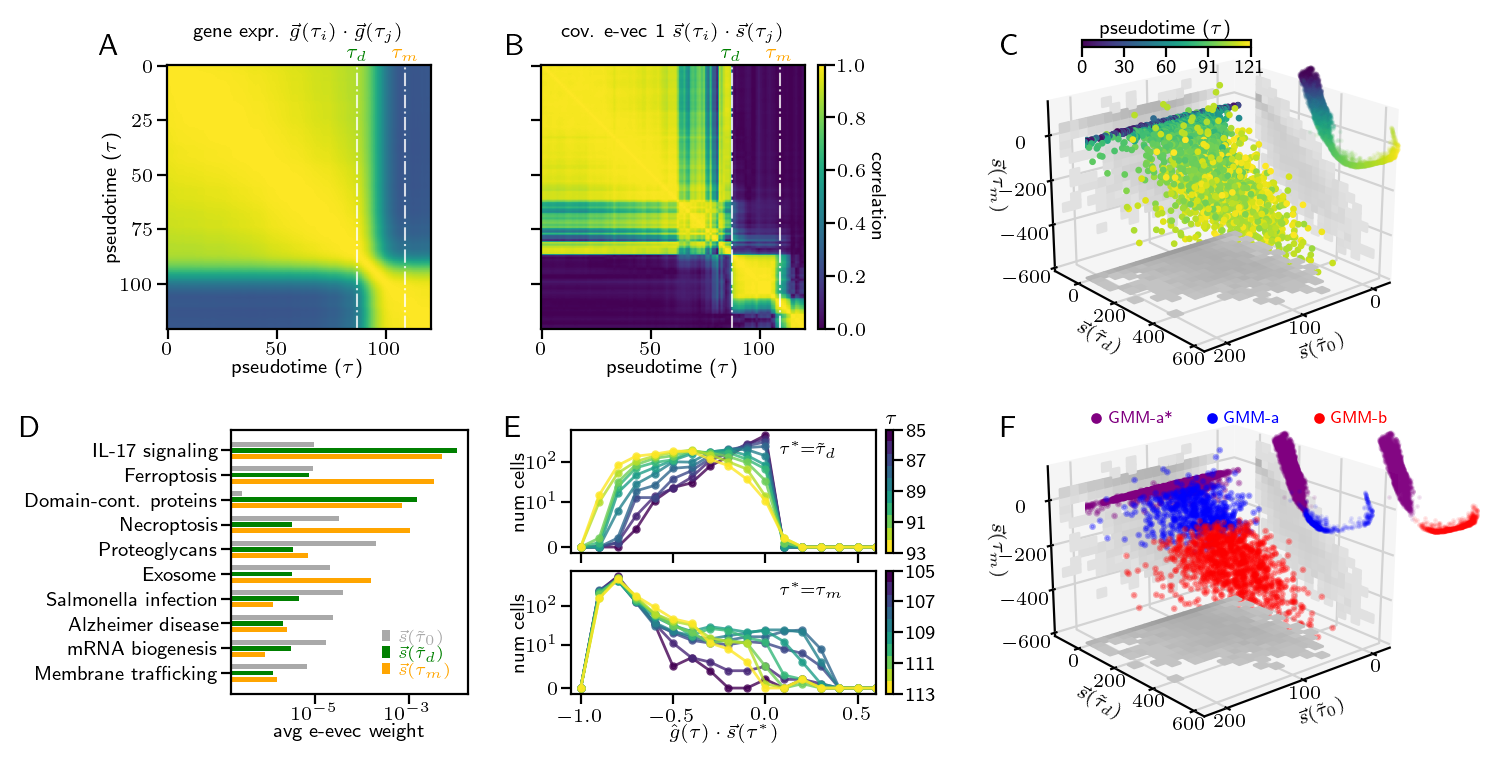

In [47]:
plt.style.reload_library()
plt.style.use('one_col_fig_7.mplstyle')
plt.rcParams['grid.color'] = "lightgray"

wfrac, hfrac = 4,4

left_marg_wid = 4
awid = 8
ab_spc = 3
bwid = awid
bbleg_spc = 0.25
bleg_wid  = 0.25
#blegc_spc = 3
cwid      = 9
cleg_leftpad_wid  = 0.5
cleg_wid=5

dmarg_wid = 2
dwid = 7
de_spc = 3
ewid = 9
eeleg_spc = 0.25
eleg_wid = 0.25
elegf_spc = 5

top_marg_ht = 1
cin_ht = 3
cleg_ht = 0.25
clegc_spc = 0.5
aht = 8
ad_spc = 3
eht = 3.75
eespc = 0.5
#fin_ht = 

wid1 = awid - dmarg_wid
wid2 = dwid - ab_spc - wid1
wid3 = bwid - de_spc - wid2
wid4 = ewid - wid3 - bbleg_spc - bleg_wid

wds = np.array([
    left_marg_wid,
    dmarg_wid,
    wid1,
    ab_spc,
    wid2,
    de_spc,
    wid3,
    bbleg_spc,
    bleg_wid,
    wid4,
    eeleg_spc,
    eleg_wid,
    elegf_spc,
    cleg_leftpad_wid,
    cleg_wid,
    cwid - cleg_wid - cleg_leftpad_wid
])

ht1 = cin_ht - eht
hts = np.array([
    top_marg_ht,
    cleg_ht,
    clegc_spc,
    cin_ht,
    aht - cin_ht,
    ad_spc,
    eht,
    ht1,
    eespc - ht1,
    eht
])

wds = np.array(wfrac*wds,dtype = int)
hts = np.array(hfrac*hts,dtype = int)


rs = np.cumsum(hts) # starting rows
cs = np.cumsum(wds) # starting cols

nr = np.sum(hts)
nc = np.sum(wds)

wid = 22/2.54
ht  = wid*nr/nc


fig = plt.figure(figsize=(wid, ht), dpi=200)

gs = gridspec.GridSpec(nr, nc)

axA  = plt.subplot( gs[rs[2]:rs[4], cs[0]:cs[2]])
axB  = plt.subplot( gs[rs[2]:rs[4], cs[3]:cs[6]])
axBL = plt.subplot( gs[rs[2]:rs[4], cs[7]:cs[8]])
axC  = plt.subplot( gs[rs[2]:rs[4], cs[12]:    ], projection='3d') 
axCL = plt.subplot( gs[rs[0]:rs[1], cs[13]:cs[14]]) 

axD    = plt.subplot( gs[rs[5]:rs[9], cs[1]:cs[4]])
axE1   = plt.subplot( gs[rs[5]:rs[6], cs[5]:cs[9]]) 
axE2   = plt.subplot( gs[rs[8]:rs[9], cs[5]:cs[9]])
axE1L  = plt.subplot( gs[rs[5]:rs[6], cs[10]:cs[11]]) 
axE2L  = plt.subplot( gs[rs[8]:rs[9], cs[10]:cs[11]]) 
axF    = plt.subplot( gs[rs[5]:rs[9], cs[12]:      ], projection='3d')

caps = ['A','B','C','D','E','F']

rcxy = [
    [rs[1], 0     , 0, 10], #A
    [rs[1], cs[2] , 0, 10], #B
    [rs[1], cs[11], 0, 15], #C
    [rs[5], 0     , 0, -1], #D
    [rs[5], cs[4] , 0, 5], #E
    [rs[5], cs[11], 0, 15] #F
]

for i in range(len(caps)):
    r,c,dr,dc = rcxy[i]
    cap_ax=plt.subplot(gs[r:r+1,c:c+1])
    cap_ax.text(s=caps[i], x=dc, y=dr,fontsize=11, fontweight='bold')
    cap_ax.axis('off')
    
#####################################
########### A and B #################
########## correlation plots ########
#####################################
pst_ax_label = r'pseudotime ($\tau$)'
im1 = axA.imshow(mu_gexp_cc,vmin=0,vmax=1)
im2 = axB.imshow(np.abs(pc1_corr),vmin=0,vmax=1)

for ax in [axA, axB]:
    ax.set_xticks([0,50,100])
    ax.set_xlabel(pst_ax_label)

axA.set_ylabel(pst_ax_label)
axB.set_yticklabels([])
plt.colorbar(im1, cax=axBL)
axBL.set_ylabel('correlation', rotation=270, labelpad=7)
axA.set_title('gene expr. '+r'$\vec{g}(\tau_i)\cdot \vec{g}(\tau_j)$', pad = 10)
axB.set_title('cov. e-vec 1  '+r'$\vec{s}(\tau_i)\cdot \vec{s}(\tau_j)$', pad=10)

######################
# bifurcation lines ##
######################
bifcols  = ['green','orange']
bcol = ['darkgray']+bifcols

zord     = [1,1]
lws      = [0.75,0.75]
tau_min  = np.array([0,0])
tau_min  = np.vstack([tau_min, tau_min]).T
uselinecols  = [False, False]
lss      = ['-.','-.']

#bifts = np.array([t_bifurc,t_bifurc_pf])
bifnms = [r'$\tau_{d}$',r'$\tau_{m}$']
bifxs  = (np.array([bifts]) - tau_min)/(npst - tau_min) #[0.8,0.6] #bifts / tf
for j in range(len(bifts)):
    for i,ax in enumerate([axA, axB]):
        ax.text(s=bifnms[j],x=bifxs[i][j],y=1.01,transform=ax.transAxes,color=bifcols[j],
                 horizontalalignment = 'center', verticalalignment='bottom',fontsize=7)
        ax.axvline(bifts[j],color='white', 
                           linestyle = lss[j], alpha=0.8,zorder=zord[i],lw=lws[i])
##############################
####### C and F ##############
#### e-vec scatter plot ######
##############################

scat_skip = 10
inset_markersize=0.5
inset_alpha = 0.1
traj_idxs = np.array(neut_psts[::scat_skip,0],dtype='int')
traj_psts = np.array(neut_psts[::scat_skip,1],dtype='int')

springX = metadata['SPRINGx'][traj_idxs]
springY = metadata['SPRINGy'][traj_idxs]

axCin    = axC.inset_axes([0.8, 0.6, 0.4, 0.4],transform=axC.transAxes)
#axFin    = axF.inset_axes([0.8, 0.6, 0.4, 0.4],transform=axF.transAxes)
axFin1    = axF.inset_axes([0.7, 0.6, 0.4, 0.4],transform=axF.transAxes)
axFin2    = axF.inset_axes([1.1, 0.6, 0.4, 0.4],transform=axF.transAxes)
axFins    = [axFin1, axFin2]

# plot points in neutrophil trajectory
colmapC = plt.cm.viridis(np.linspace(0,1,traj_idxs.shape[0]))
colsC   = colmapC[np.array(traj_psts/scat_skip,dtype='int')]

proj = pc1_proj[traj_idxs][:,evec_ts2].T
axC.scatter(proj[0],proj[1],proj[2], c=colsC, alpha=1,s=2)
axCin.scatter(springX,springY, c=colsC,alpha=inset_alpha,s=inset_markersize)

cmap   = plt.cm.get_cmap('viridis', traj_idxs.shape[0])
sm     = plt.cm.ScalarMappable(cmap=cmap)
nticks = 5
plt.colorbar(sm, cax=axCL, orientation='horizontal',ticks=np.linspace(0,1,nticks))
axCL.set_xticklabels(np.array(np.around(np.linspace(0,npst,nticks)),dtype='int'))#, fontsize=ab_cap_fs)
axCL.set_title(pst_ax_label)#, fontsize=ab_cap_fs)

#### for axF
clust_cols = ['red', 'blue']
colsF      = np.array(['purple']+clust_cols)
clabs      = np.array(['GMM-a*', 'GMM-b', 'GMM-a'])
disp_ord   = np.array([0,2,1])
for i in disp_ord: # best order for display (?)
    _,idxs,_ = np.intersect1d(traj_idxs, traj_idxs_split_branch[i], return_indices=True)
    projF = pc1_proj[traj_idxs[idxs]][:,evec_ts2].T
    axF.scatter(projF[0],projF[1],projF[2], c=colsF[i],alpha=0.3, s=2,label=clabs[i])
    #axFin.scatter(springX[idxs],springY[idxs], c=colsF[i],alpha=inset_alpha, s=inset_markersize)

    if i == 0:
        for axFin in axFins:
            axFin.scatter(springX[idxs],springY[idxs], c=colsF[i],alpha=inset_alpha, s=inset_markersize)
    else:
        axFins[disp_ord[i]-1].scatter(springX[idxs],springY[idxs], c=colsF[i],alpha=inset_alpha, 
                                      s=inset_markersize)


leg = axF.legend(labelspacing=0,handlelength=0.5, labelcolor=colsF[disp_ord], handletextpad=0.5, 
       frameon=False, markerscale=2, fontsize=6, loc=[-0,0.99], ncol=3)

for lh in leg.legendHandles:
    lh.set_alpha(1)
#axFin.legend(labelspacing=0,handlelength=0.5)#,labelcolor='mfc')

# ### inset formatting ###

springXlims = [np.amin(springX), np.amax(springX)]
springYlims = [np.amin(springY), np.amax(springY)]

#for ax in [axCin, axFin]:
for ax in [axCin, axFin1, axFin2]:
    ax.set_xlim(springXlims[0]-100,springXlims[1]+100)
    ax.set_ylim(springYlims[0]-100,springYlims[1]+100)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.patch.set_alpha(0)
    ax.axis('off')


    
axlabs = [r'$\vec{s}(\tilde{\tau}_0)$', r'$\vec{s}(\tilde{\tau}_d)$',r'$\vec{s}(\tau_m)$']
lpads = [-15,-15,-13]
my_cmap = copy.copy(plt.cm.binary)
my_cmap.set_bad(color='white')
my_cmap.set_under(color='none')
facemins = np.array([-20,-120,-600])
ijk = np.array([[0,1,2],[2,1,0],[0,2,1]])


for ax in [axC, axF]:

    ax.set_xlabel(axlabs[0], labelpad=lpads[0])
    ax.set_ylabel(axlabs[1], labelpad=lpads[1])
    ax.set_zlabel(axlabs[2], labelpad=lpads[2])

    ax.view_init(20, 50)
    ax.margins(0)
    ax.autoscale_view('tight')
    ax.dist=7

    ax.set_xlim(xmin=facemins[0])
    ax.set_ylim(ymin=facemins[1])
    ax.set_zlim(zmin=facemins[2])
    ax.tick_params(axis='x', which='major', pad=-7)
    ax.tick_params(axis='y', which='major', pad=-7)
    ax.tick_params(axis='z', which='major', pad=-4)
    #axC.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    panecolor = colors.to_rgba('whitesmoke')
    ax.w_xaxis.set_pane_color(panecolor)
    ax.w_yaxis.set_pane_color(panecolor)
    ax.w_zaxis.set_pane_color(panecolor)
    
for i,j,k in ijk[0:3]:
    dens, xbinlim, ybinlim = np.histogram2d(proj[i], proj[j], density=True,bins=20)
    xedge, yedge           = get_bin_mesh(xbinlim, ybinlim)
    zedge                  = facemins[k]*np.ones(xedge.shape)
    xyzedge = np.array([xedge, yedge, zedge])
    for ax in [axC, axF]:
        ax.plot_surface(xyzedge[i], xyzedge[j], xyzedge[k], 
                        facecolors=my_cmap(dens_norm(dens.T)*0.2),clip_on=False)


        
########################
#### D: KEGG ###########
########################

yoff = [0.25,0,-0.25]


labs = axlabs #[r'$\tau_0$', r'$\tau_d$',r'$\tau_m$']

lev = 2
#for i in range(1,nproc_lev):
    
top_wts  = proc_wts_norm[lev][top_proc_idxs_flat[lev]]
proc_ord = np.argsort(np.sum(top_wts,axis=1))
nbar     = top_wts.shape[0]

for ti in range(len(evec_ts)):
    axD.barh(np.arange(nbar)+yoff[ti], top_wts[proc_ord,ti], color = bcol[ti], 
                  height=0.2, log=True, 
                  label=labs[ti], align='center')

bar_names = [ko_id_def2[lev][kidx2ko_id[lev][j]] for j in top_proc_idxs_flat[lev]]
bar_names = np.array([x.split('[',1)[0].rstrip() for x in bar_names])
axD.set_yticks(np.arange(nbar))
axD.set_yticklabels(bar_names[proc_ord], fontsize=7)#, rotation=90)
axD.set_xlabel('avg e-evec weight')
axD.legend(labelspacing=0,handlelength=0.5, labelcolor='mfc', handletextpad=0.5, 
       frameon=False, markerscale=0.5, fontsize=6)


        
###########################################
########### E: distributions ##############
###########################################
ts = np.array([np.arange(85,95,1),np.arange(105,115,1)])
cols = plt.cm.viridis(np.linspace(0,1,len(ts[0])))

cmap   = plt.cm.get_cmap('viridis', ts.shape[1])
sm     = plt.cm.ScalarMappable(cmap=cmap)
nticks = 5

# xlabs = [r'$\hat{g}(\tau)\cdot\vec{s}(\tau_d)$',
#          r'$\hat{g}(\tau)\cdot\vec{s}(\tau_m)$']

axs  = [axE1, axE2]
axLs = [axE1L, axE2L]
xtix = np.linspace(-1,0.5,4)
mulens = r'\setlength{\thickmuskip}{-1mu}\setlength{\thinmuskip}{0mu}\setlength{\medmuskip}{0mu}'
tlabs = [mulens+x for x in [r'$\tau^*=\tilde{\tau}_d$',r'$\tau^*=\tau_m$']]

for i in range(ts.shape[0]):
    for t in range(ts.shape[1]):
        axs[i].plot(hbin_mids[i+1], bif_proj_hists[i+1,ts[i,t]], 'o-',color = cols[t], 
                    alpha=0.8,label=ts[i,t])
        axs[i].set_yscale('symlog',linthresh=10)
        
    axs[i].set_xlim(-1.05,0.6)
    
   
    plt.colorbar(sm, cax=axLs[i], orientation='vertical',ticks=np.linspace(0,1,nticks))
    axLs[i].invert_yaxis()
    axLs[i].set_yticklabels(ts[i,::2])#, fontsize=ab_cap_fs)
    #axLs[i].set_ylabel(r'$\tau$',rotation=270,labelpad=12)#, fontsize=ab_cap_fs)

    
    axs[i].set_ylabel('num cells')
    axs[i].set_xticks(xtix)
    axs[i].text(s=tlabs[i], x=0.68, y=0.8, transform=axs[i].transAxes, fontsize=6)

    axs[0].set_xticklabels([])
    
axLs[0].set_title(r'$\tau$')
axs[1].set_xlabel(r'$\hat{g}(\tau)\cdot\vec{s}(\tau^*)$')
    #axs[i].set_xlabel(xlabs[i])
        
        
plt.savefig('{0}/evec_fig2.pdf'.format(figdir), bbox_inches='tight')
        

In [162]:
bif_proj_hists.shape

(2, 121, 21)

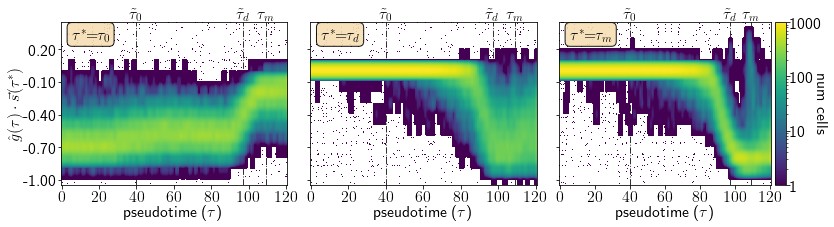

In [260]:
fig,axs=plt.subplots(1,3, figsize=(13,3))
##############################################
# 1d distributions...########################
###############################################
log_bif_proj_hists = [np.log10(x, out = np.zeros_like(x)+np.nan, where=x>0) for x in bif_proj_hists]
formatter = LogFormatter(10, labelOnlyBase=False) 
colnorm = matplotlib.colors.LogNorm(vmin=1, vmax=1000)


#axs[0].set_xticklabels([])

ylabs = [r'$\hat{g}(\tau)\cdot\vec{s}(\tau_d)$',
         r'$\hat{g}(\tau)\cdot\vec{s}(\tau_m)$']

tick_skip = 3
nbin = bif_proj_hists.shape[1]
pmin = -1.1
pmax = 0.4
bmin = np.argmin(np.abs(hbin_mids[0] - pmin))
bmax = np.argmin(np.abs(hbin_mids[0] - pmax))+1
tlabs = [mulens+x for x in [r'$\tau^*=\tau_0$',r'$\tau^*=\tau_d$',r'$\tau^*=\tau_m$']]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)

for i,ax in enumerate(axs):
    im = ax.imshow(bif_proj_hists[i,:,bmin:bmax].T,aspect='auto',norm=colnorm, zorder=2, origin='lower')

    #ax.set_ylabel(ylabs[i])
    ax.set_yticks(np.arange(0,len(hbin_mids[i,bmin:bmax]),tick_skip))
    ax.set_yticklabels(['{0:.2f}'.format(x) for x in hbin_mids[i,bmin:bmax:tick_skip]])
    ax.set_xlabel(pst_ax_label)
    ax.text(s=tlabs[i], x=0.05, y=0.9, transform=ax.transAxes, fontsize=16, bbox=props)
    
    if i > 0:
        ax.set_yticklabels([])


axs[0].set_ylabel(r'$\hat{g}(\tau)\cdot\vec{s}(\tau^*)$')
ax_divider = make_axes_locatable(axs[2])
cax = ax_divider.append_axes("right", size="5%", pad="2%")

plt.colorbar(im, cax=cax, orientation='vertical', format=formatter)
cax.set_ylabel('num cells', rotation=270, labelpad = 6)

for ax in axs:
    mf.set_axs_fontsize(ax, 16)
mf.set_axs_fontsize(cax, 16)

plt.subplots_adjust(wspace=0.1)

#bifts = np.array([t_bifurc,t_bifurc_pf])

tau_min  = np.array([0,0])
tau_min  = np.vstack([tau_min, tau_min]).T
lss      = ['-.','-.','-.']
bifnms = [r'$\tilde{\tau}_{0}$',r'$\tilde{\tau}_{d}$',r'$\tau_{m}$']
bifxs  = evec_ts2 #(np.array([evec_]) - tau_min)/(npst - tau_min) #[0.8,0.6] #bifts / tf
for j in range(nevec):
    for i,ax in enumerate(axs):
        ax.text(s=bifnms[j],x=evec_ts2[j]/npst,y=1.01,transform=ax.transAxes, color='k',
                 horizontalalignment = 'center', verticalalignment='bottom',fontsize=16)
        axs[i].axvline(evec_ts2[j],color='k', linestyle = lss[j], alpha=0.8,zorder=0,lw=1)

plt.savefig('{0}/evec_proj_dists.pdf'.format(figdir), bbox_inches='tight')


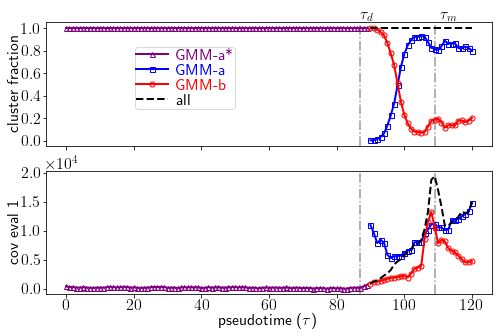

In [261]:
fig,axs=plt.subplots(2,1, figsize=(8,5))

##########################
######axs[1]: eval plot ##
##########################

clust_cols = ['red', 'blue']
colsF      = np.array(['purple','black']+clust_cols)
clabs      = np.array(['GMM-a*', 'all', 'GMM-b', 'GMM-a'])
mstyles    = ['^-','--','o-','s-'] 

clust1_frac   = nc1/nc_all
pst_eig1_n    = pst_eig1 - np.amin(pst_eig1)
clust1_eig1_n = gmm_cov_eval[:,1]-np.nanmin(gmm_cov_eval[:,1])
clust0_eig1_n = gmm_cov_eval[:,0]
fs = 16
trngs      = [np.arange(t0), np.arange(t0,npst), np.arange(t0,npst), np.arange(t0,npst)]
dats0      = [clust1_frac[0:t0], np.ones(npst-t0), clust1_frac[t0:], 1-clust1_frac[t0:]]
dats1      = [pst_eig1_n[0:t0], pst_eig1_n[t0:], clust1_eig1_n[t0:], clust0_eig1_n[t0:]]

dats = [dats0, dats1]
dord = [0,3,2,1]
#nclust_cell = []

for i in range(len(dats)):
    for j in dord:
        axs[i].plot(trngs[j], dats[i][j], mstyles[j], color=colsF[j], label = clabs[j], lw=2, markersize=5, 
                    fillstyle='none')

axs[0].legend(labelspacing=0, labelcolor=colsF[dord], handletextpad=0.5, 
           frameon=True, framealpha=0.75, borderpad=0.05, fontsize=fs, loc=(0.2,0.3))

axs[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[1].yaxis.get_offset_text().set_fontsize(fs)

axs[1].set_xlabel(r'pseudotime ($\tau$)')
axs[0].set_ylabel('cluster fraction')
axs[1].set_ylabel('cov eval 1')

axs[1].set_xlabel(pst_ax_label)
axs[0].set_xticklabels([])

for ax in axs:
    mf.set_axs_fontsize(ax,16)
    
tau_min  = np.array([0,0])
tau_min  = np.vstack([tau_min, tau_min]).T
lss      = ['-.','-.','-.']
bifnms = [r'$\tau_{d}$',r'$\tau_{m}$']
bifxs  = evec_ts[1:] #(np.array([evec_]) - tau_min)/(npst - tau_min) #[0.8,0.6] #bifts / tf
for j in range(len(evec_ts[1:])):
    axs[0].text(s=bifnms[j],x=evec_ts[j+1]/npst,y=1.01,color='k', transform=axs[0].transAxes,
                 horizontalalignment = 'center', verticalalignment='bottom',fontsize=fs)
    for i,ax in enumerate(axs):
        ax.axvline(evec_ts[j+1],color='k', linestyle = lss[j], alpha=0.4,zorder=0,lw=1.5)

plt.savefig('{0}/clust_frac_evals.pdf'.format(figdir), bbox_inches='tight')


In [266]:
gexp_sn       = gexp_full[bin_cidxs[evec_ts[2]]]
gexp_sn_ctr   = gexp_sn - np.mean(gexp_sn, axis=0)
gexp_sn_norms = np.linalg.norm(gexp_sn_ctr, axis=0)
gexp_sn_normd = np.divide(gexp_sn_ctr, gexp_sn_norms, where = gexp_sn_norms > 0, out=np.zeros_like(gexp_sn_ctr))
#fth1_ccs = gexp_sn_normd[:,gidxs[3]].T.dot(gexp_sn_normd)

In [267]:
ngs = 24
#gidxs2 = np.argsort(-np.abs(fth1_ccs))[ngs:2*ngs]
gidxs2 = np.argsort(-pst_pc1_sq[evec_ts[2]])[0:ngs]
#gidxs2 = np.where(np.abs(fth1_ccs)>0.5)[0]
#gidxs2 = np.setdiff1d(gidxs2,gidxs[3])
gdats  = gexp_sn[:,gidxs2].T
gmins  = np.array([np.amin(gdat[gdat>0]) for gdat in gdats])
gmaxs  = np.amax(gdats, axis=1)
gmaxs = gmaxs + gmins # like adding epsilon..

nbins  = 20
gbins_lin   = np.array([np.hstack([[-gmins[i]],np.linspace(gmins[i],gmaxs[i], nbins)]) for i in range(ngs)])
gbins_log   = np.array([np.hstack([[-gmins[i]],np.logspace(np.log10(gmins[i]),np.log10(gmaxs[i]), nbins)]) 
                        for i in range(ngs)])

gbin_ctrs_lin = 0.5*(gbins_lin[:,1:]+gbins_lin[:,:-1])
gbin_ctrs_log = 0.5*(gbins_log[:,1:]+gbins_log[:,:-1])

ghists_lin    = np.array([np.histogram(gdats[i], bins=gbins_lin[i])[0] for i in range(ngs)])
ghists_log    = np.array([np.histogram(gdats[i], bins=gbins_log[i])[0] for i in range(ngs)])

ghists_lin_split    = np.array([[np.histogram(gdats[i,gmm_pred_idxs[evec_ts[2]][j]], bins=gbins_lin[i])[0] 
                                                    for j in range(nbranch)]
                                              for i in range(ngs)])
                                 
ghists_log_split    = np.array([[np.histogram(gdats[i,gmm_pred_idxs[evec_ts[2]][j]], bins=gbins_log[i])[0] 
                                                    for j in range(nbranch)]
                                              for i in range(ngs)])

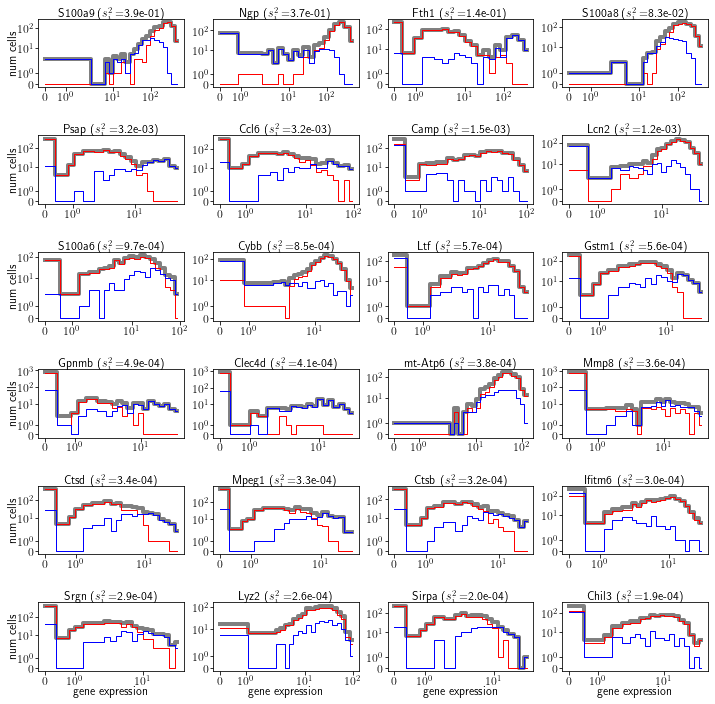

In [272]:
nrow = 6
ncol = int(np.ceil(ngs/nrow))
fig,axs=plt.subplots(nrow,ncol,figsize=(12,12))

for i,t in enumerate(gidxs2):
    
    r,c = int(i/ncol), i%ncol
    ax  = axs[r,c]
    axs[r,c].step(gbin_ctrs_log[i], ghists_log[i], where='mid', color='gray', linewidth=4)
    
    for j in range(nbranch):
        ax.step(gbin_ctrs_log[i], ghists_log_split[i,j], where='mid', color = clust_cols[j])

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.set_title('{0} ($s_i^2=${1:.1e})'.format(gnms[gidxs2[i]],pst_pc1_sq[evec_ts[2], gidxs2[i]]))
    
    if r == nrow-1:
        ax.set_xlabel('gene expression')
    if c == 0:
        ax.set_ylabel('num cells')
    
    mf.set_axs_fontsize(ax, 12)

plt.subplots_adjust(hspace=0.7,wspace=0.2)
plt.savefig('{0}/clust_gene_distr.pdf'.format(figdir), bbox_inches='tight')


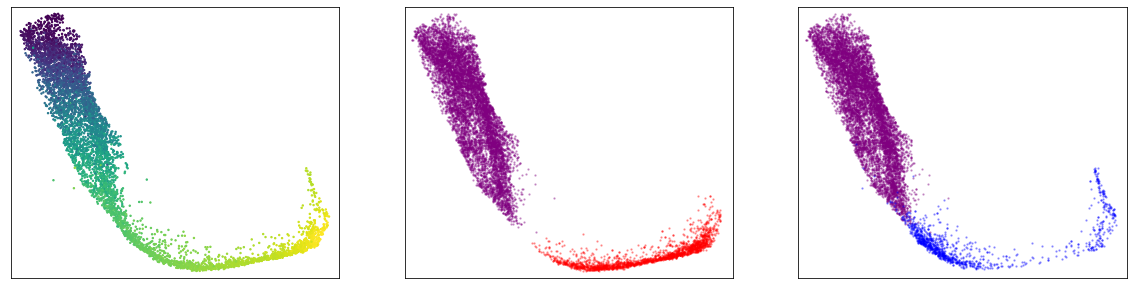

In [44]:
fig,axs=plt.subplots(1,3,figsize=(20,5))


# plot non-neut points
traj_idxs = np.array(neut_psts[:,0],dtype='int')
springXlims = [np.amin(metadata['SPRINGx'][traj_idxs[::scat_skip]]),
               np.amax(metadata['SPRINGx'][traj_idxs[::scat_skip]])]
springYlims = [np.amin(metadata['SPRINGy'][traj_idxs[::scat_skip]]),
               np.amax(metadata['SPRINGy'][traj_idxs[::scat_skip]])]

for ax in axs:
    ax.set_xlim(springXlims[0]-100,springXlims[1]+100)
    ax.set_ylim(springYlims[0]-100,springYlims[1]+100)
    ax.set_xticks([])
    ax.set_yticks([])

# plot points in neutrophil trajectory
colsC = plt.cm.viridis(np.linspace(0,1,traj_idxs.shape[0]))

axs[0].scatter(metadata['SPRINGx'][traj_idxs[::scat_skip]],metadata['SPRINGy'][traj_idxs[::scat_skip]], 
               c=colsC[np.array(neut_psts[:,1],dtype='int')][::scat_skip],alpha=1,s=2)

#### for axF
clust_cols = ['red', 'blue']
colsF      = ['purple']+clust_cols
for i in range(3):#len(traj_idxs_split)):
    spx = metadata['SPRINGx'][traj_idxs_split_branch[i][::scat_skip]],
    spy = metadata['SPRINGy'][traj_idxs_split_branch[i][::scat_skip]]
    if i==0:
        for ax in axs[1:]:
            ax.scatter(spx,spy, c=colsF[i],alpha=0.3, s=2)
    elif i==1:
        axs[1].scatter(spx,spy, c=colsF[i],alpha=0.3, s=2)
    else:
        axs[2].scatter(spx,spy, c=colsF[i],alpha=0.3, s=2)




Text(0.5, 1.0, 'num cells')

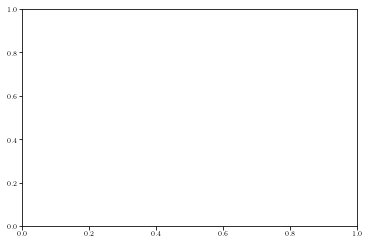

In [263]:
##########################
######axE: eval plot #####
###########################

nc_col = 'purple'
nc = np.array(list(map(len,bin_cidxs)))
axE.plot(gmm_cov_eval[:,0]-np.amin(gmm_cov_eval[:,0]),'o-', label='cluster A', color = clust_cols[0])
axE.plot(gmm_cov_eval[:,1],'o-', label='cluster B', color=clust_cols[1])
axE.plot(pst_eig1 - np.amin(pst_eig1),'ko-', label = 'all')
axE.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axE.set_xlabel(r'pseudotime ($\tau$)')
axE.set_ylabel('cov eval 1')

axE2 = axE.twinx()
axE2.plot(nc1/nc,'--', color = nc_col)
axE2.set_ylabel('cluster B fraction',rotation=270, labelpad=8, color = nc_col)

axE2.tick_params(axis='y', labelcolor=nc_col)
axE2.spines['left'].set_color(nc_col)
axE2.spines['right'].set_color(nc_col)

axE.legend(labelspacing=0, handlelength=0.5, labelcolor='mfc', handletextpad=0.5, 
           frameon=True, framealpha=0.75, borderpad=0.05)
tau_min_E = 70
axE.set_xlim(xmin=tau_min_E)




#######
#fs=12
#axlabs = ['initial', '1-to-1', '1-to-many']
#axlabs = [r'$\tau_0$', r'$\tau_d$',r'$\tau_m$']

##############################################
# 1d distributions...########################
###############################################
log_bif_proj_hists = [np.log10(x, out = np.zeros_like(x)+np.nan, where=x>0) for x in bif_proj_hists]

#A = np.random.rand(50,50)*50
#plt.imshow(A, norm=matplotlib.colors.LogNorm())
formatter = LogFormatter(10, labelOnlyBase=False) 
#cb = plt.colorbar(ticks=[1,5,10,20,50], format=formatter)

#im3 = axD1.imshow(log_bif_proj_hists[1].T,aspect='auto',zorder=1, vmin=0, vmax=3)
#im4 = axD2.imshow(log_bif_proj_hists[0].T,aspect='auto',zorder=1, vmin=0, vmax=3)
colnorm = matplotlib.colors.LogNorm(vmin=1, vmax=1000)

#nticks = 5
#axDL.set_xticklabels(np.array(np.around(np.linspace(0,npst,nticks)),dtype='int'))#, fontsize=ab_cap_fs)


        
axD1.set_xticklabels([])
axD2.set_xlabel(pst_ax_label)

ylabs = [r'$\hat{g}(\tau)\cdot\vec{s}(\tau_d)$',
         r'$\hat{g}(\tau)\cdot\vec{s}(\tau_m)$']

tick_skip = 10
nbin = bif_proj_hists.shape[1]
pmin = -1.1
pmax = 0.5
bmin = np.argmin(np.abs(hbin_mids - pmin))
bmax = np.argmin(np.abs(hbin_mids - pmax))+1

for i,ax in enumerate([axD1, axD2]):
    im = ax.imshow(bif_proj_hists[i,:,bmin:bmax].T,aspect='auto',norm=colnorm, zorder=2, origin='lower')

    ax.set_ylabel(ylabs[i])
    ax.set_yticks(np.arange(0,len(hbin_mids[i,bmin:bmax]),tick_skip))
    ax.set_yticklabels(['{0:.2f}'.format(x) for x in hbin_mids[i,bmin:bmax:tick_skip]])
    

plt.colorbar(im, cax=axDL, orientation='horizontal', format=formatter)
axDL.set_title('num cells')





#plt.savefig('{0}/evec_fig.pdf'.format(figdir), bbox_inches='tight')


In [109]:
#taud_evec_clusteroid = np.argmin(np.sum(taud_evec_dists,axis=1)) + evec_ts[1]

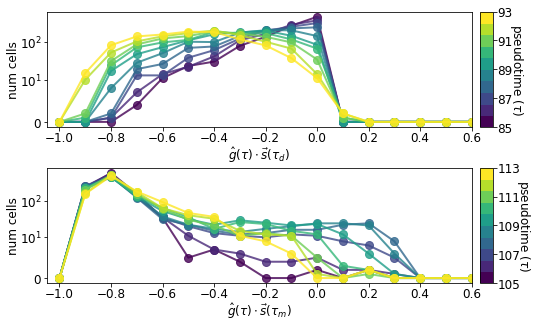

In [213]:
fig,axs=plt.subplots(2,1,figsize=(8,5))
ts = np.array([np.arange(85,95,1),np.arange(105,115,1)])
cols = plt.cm.viridis(np.linspace(0,1,len(ts[0])))

cmap   = plt.cm.get_cmap('viridis', ts.shape[1])
sm     = plt.cm.ScalarMappable(cmap=cmap)
nticks = 5


xlabs = [r'$\hat{g}(\tau)\cdot\vec{s}(\tau_d)$',
         r'$\hat{g}(\tau)\cdot\vec{s}(\tau_m)$']

for i in range(ts.shape[0]):
    for t in range(ts.shape[1]):
        #axs.step(hbin_mids[0], bif_proj_hists[0,ts[t]], color = cols[t], linewidth=2,alpha=1)
        axs[i].plot(hbin_mids[i], bif_proj_hists[i,ts[i,t]], 'o-',color = cols[t], linewidth=2,
                    alpha=0.8,markersize=8, label=ts[i,t])
        axs[i].set_yscale('symlog',linthresh=10)
    axs[i].set_xlim(-1.05,0.6)
    
    ax_divider = make_axes_locatable(axs[i])

    cax = ax_divider.append_axes("right", size="3%", pad="2%")

   
    plt.colorbar(sm, cax=cax, orientation='vertical',ticks=np.linspace(0,1,nticks))
    cax.set_yticklabels(ts[i,::2])#, fontsize=ab_cap_fs)
    cax.set_ylabel(pst_ax_label,rotation=270,labelpad=12)#, fontsize=ab_cap_fs)
    
    axs[i].set_ylabel('num cells')
    
    axs[i].set_xlabel(xlabs[i])
    mf.set_axs_fontsize(axs[i],12)
    mf.set_axs_fontsize(cax,12)


plt.subplots_adjust(hspace=0.35)

plt.savefig('{0}/pst_distr.pdf'.format(figdir), bbox_inches='tight')


    #axs[i].legend()

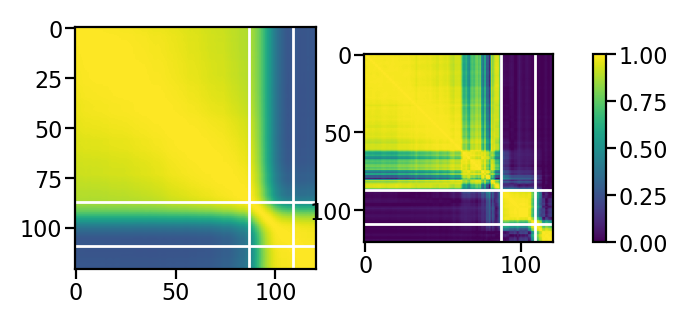

In [14]:
# side by side projections
plt.style.use('one_col_fig')
wid = 8.7/2.54
nr = 1
nc = 2
ht  = wid*nr/nc

fig,axs = plt.subplots(1,2,figsize=(wid, ht), dpi=200) 
im1 = axs[0].imshow(mu_gexp_cc,vmin=0,vmax=1)
im2 = axs[1].imshow(np.abs(pc1_corr),vmin=0,vmax=1)


for t in bifts:
    for ax in axs:
        ax.axvline(t, color='white')
        ax.axhline(t, color='white')
        
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="7%", pad=0.2)

plt.colorbar(im1, cax=cax)

0 1 2
2 1 0
0 2 1


(-600.0, 135.18287668841086)

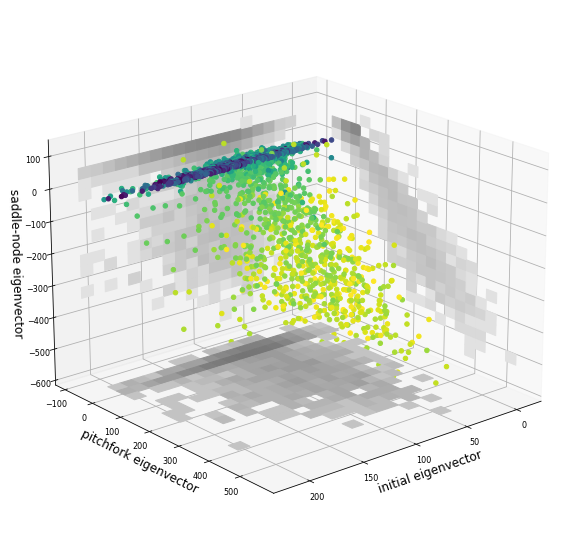

In [228]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
skip = 10

traj_idxs = np.array(neut_psts[:,0],dtype='int')

# plot points in neutrophil trajectory
skip = 20
cols = plt.cm.viridis(np.linspace(0,1,traj_idxs.shape[0]))

# cols = ['purple','blue','red']
# skip = 10
# for i in range(3):#len(traj_idxs_split)):
#     proj = gexp_pc1_proj[traj_idxs_split_branch[i][::skip]][:,evec_ts].T
#     ax.scatter(proj[0],proj[1],proj[2], c=cols[i],alpha=0.3)
    
#, fontsize=14, rotation=270)
#ax.tick_params(axis='z',fontsize=14)
#ax.zaxis._axinfo['tick']['fontsize']=20

#mf.set_axs_fontsize(ax, 14)
evec_ts = np.hstack([[0],bifts])
cols = plt.cm.viridis(np.linspace(0,1,traj_idxs.shape[0]))
proj = pc1_proj[traj_idxs[::skip]][:,evec_ts].T
ax.scatter(proj[0],proj[1],proj[2], c=cols[np.array(neut_psts[:,1],dtype='int')][::skip],alpha=1)

fs=12
ax.set_xlabel('initial eigenvector', fontsize=fs)
ax.set_ylabel('pitchfork eigenvector', fontsize=fs)
ax.set_zlabel('saddle-node eigenvector', fontsize=fs,rotation=180)
ax.view_init(20, 50)

my_cmap = copy.copy(plt.cm.binary)
my_cmap.set_bad(color='white')
my_cmap.set_under(color='none')

facemins = np.array([-20,-120,-600])
ijk = np.array([[0,1,2],[2,1,0],[0,2,1]])
for i,j,k in ijk[0:3]:
    print(i,j,k)
    dens, xbinlim, ybinlim = np.histogram2d(proj[i], proj[j], density=True,bins=20)
    xedge, yedge           = get_bin_mesh(xbinlim, ybinlim)
    zedge                  = facemins[k]*np.ones(xedge.shape)
    xyzedge = np.array([xedge, yedge, zedge])
    ax.plot_surface(xyzedge[i], xyzedge[j], xyzedge[k], facecolors=my_cmap(dens_norm(dens.T)*0.4))


ax.set_xlim(xmin=facemins[0])
ax.set_ylim(ymin=facemins[1])
ax.set_zlim(zmin=facemins[2])


#norm=colors.LogNorm(vmin=np.amin(dens[dens!=0]), vmax=np.amax(dens[dens!=0])), cmap='viridis')

#ax.hexbin(proj[0], proj[1], zdir='z', zs=-600)#, offset=-600, cmap=plt.cm.coolwarm)
#ax.contour(proj[0], proj[1], proj[2], zdir='x', offset=-20, cmap=plt.cm.coolwarm)
#ax.contour(proj[0], proj[1], proj[2], zdir='y', offset=-110, cmap=plt.cm.coolwarm)

#ax.contour(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
#ax.contour(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

# ax.scatter(gexp_pc1_proj[traj_idxs[::skip],evec_ts[0]],
#            gexp_pc1_proj[traj_idxs[::skip],evec_ts[1]], 
#            gexp_pc1_proj[traj_idxs[::skip],evec_ts[2]],
#           c=cols[np.array(neut_psts[:,1],dtype='int')][::skip],alpha=1)


# ax.scatter(metadata['SPRINGx'][traj_idxs[::skip]],metadata['SPRINGy'][traj_idxs[::skip]], 
#         c=cols[np.array(neut_psts[:,1],dtype='int')][::skip],alpha=0.5)


In [193]:
evec_ts

array([  0,  87, 109])

2 0 1
0 1 2
1 2 0


/var/folders/z4/nbwfq_mx3_j5l6mnpf_24k180000gn/T/ipykernel_3935/3706863352.py:12: RuntimeWarning: divide by zero encountered in log10
  axs[n].imshow(np.log10(dens.T))


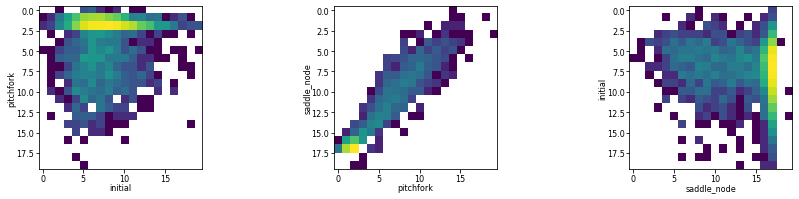

In [194]:
fig,axs=plt.subplots(1,3,figsize=(15,3))
facemins = np.array([-20,-120,-600])
ijk = np.array([[0,1,2],[1,2,0],[2,0,1]])
axlabels = ['initial', 'pitchfork','saddle_node']
for n in range(ijk.shape[0]):
    print(i,j,k)
    i,j,k = ijk[n]
    dens, xbinlim, ybinlim = np.histogram2d(proj[i], proj[j], density=True,bins=20)
    #xedge, yedge           = get_bin_mesh(xbinlim, ybinlim)
    #zedge                  = facemins[k]*np.ones(xedge.shape)
    #xyzedge = np.array([xedge, yedge, zedge])
    axs[n].imshow(np.log10(dens.T))
    axs[n].set_xlabel(axlabels[i])
    axs[n].set_ylabel(axlabels[j])


In [172]:
plt.cm.viridis(-2)

(0.267004, 0.004874, 0.329415, 1.0)

In [98]:
xx,yy=np.meshgrid(xedge, yedge)
xx.shape

(21, 21)

/var/folders/z4/nbwfq_mx3_j5l6mnpf_24k180000gn/T/ipykernel_3935/2291392227.py:2: RuntimeWarning: divide by zero encountered in log10
  axs[0].imshow(np.log10(bif_proj_hists[1]).T,aspect='auto',zorder=1)
/var/folders/z4/nbwfq_mx3_j5l6mnpf_24k180000gn/T/ipykernel_3935/2291392227.py:3: RuntimeWarning: divide by zero encountered in log10
  axs[1].imshow(np.log10(bif_proj_hists[0]).T,aspect='auto',zorder=1)


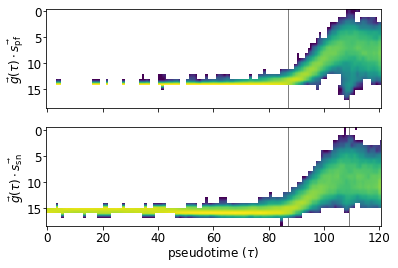

In [80]:
fig,axs = plt.subplots(2,1)
axs[0].imshow(np.log10(bif_proj_hists[1]).T,aspect='auto',zorder=1)
axs[1].imshow(np.log10(bif_proj_hists[0]).T,aspect='auto',zorder=1)

for t in bifts:
    for ax in axs:
        ax.axvline(t, color='gray',zorder=0)

        
for ax in axs:
    mf.set_axs_fontsize(ax,12)

axs[0].set_xticklabels([])
axs[1].set_xlabel(r'pseudotime ($\tau$)')

ylabs = [r'$\vec{g}(\tau)\cdot\vec{s_{\rm pf}}$',r'$\vec{g}(\tau)\cdot\vec{s_{\rm sn}}$']
for i,ax in enumerate(axs):
    ax.set_ylabel(ylabs[i])

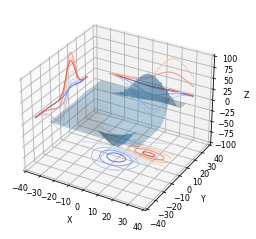

In [56]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

ax = plt.figure().add_subplot(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)

# Plot the 3D surface
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)

# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph.
ax.contour(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
ax.contour(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
ax.contour(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

ax.set(xlim=(-40, 40), ylim=(-40, 40), zlim=(-100, 100),
       xlabel='X', ylabel='Y', zlabel='Z')

plt.show()

/var/folders/z4/nbwfq_mx3_j5l6mnpf_24k180000gn/T/ipykernel_3935/1543910271.py:2: RuntimeWarning: divide by zero encountered in log10
  axs.imshow(np.log10(dens))


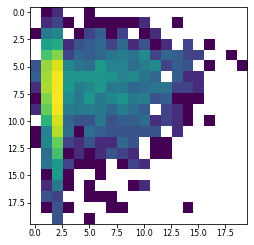

In [124]:
fig,axs=plt.subplots()
axs.imshow(np.log10(dens))

In [59]:
X.shape

(120, 120)

In [61]:
Y.shape

(120, 120)

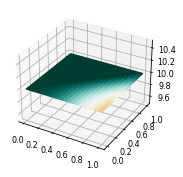

In [112]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# create a 21 x 21 vertex mesh
xx, yy = np.meshgrid(np.linspace(0,1,21), np.linspace(0,1,21))

# create vertices for a rotated mesh (3D rotation matrix)
X =  xx 
Y =  yy
Z =  10*np.ones(X.shape)

# create some dummy data (20 x 20) for the image
data = np.cos(xx) * np.cos(xx) + np.sin(yy) * np.sin(yy)

# create the figure
fig = plt.figure()

# show the reference image
# ax1 = fig.add_subplot(121)
# ax1.imshow(data, cmap=plt.cm.BrBG, interpolation='nearest', origin='lower', extent=[0,1,0,1])

# show the 3D rotated projection
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=plt.cm.BrBG(data), shade=False)

In [110]:
data.shape

(21, 21)

In [111]:
plt.cm.BrBG(data).shape

(21, 21, 4)

In [303]:
pst_pc1.shape

(121, 25289)

In [17]:
# gene exploration...
load_min          = 1e-12
nbin              = 300
pst_pc1_sq        = pst_pc1**2
load_bins_log     = np.hstack([[-load_min],np.logspace(np.log10(load_min),0,nbin)])
load_hists_log    = np.array([np.histogram(pst_pc1_sq[t], bins=load_bins_log)[0] for t in range(nt)])
load_bin_ctrs_log = 0.5*(load_bins_log[1:]+load_bins_log[:-1])

load_bins_lin     = np.hstack([[-load_min],np.linspace(load_min,1,nbin)])
load_hists_lin    = np.array([np.histogram(pst_pc1_sq[t], bins=load_bins_lin)[0] for t in range(nt)])
load_bin_ctrs_lin = 0.5*(load_bins_lin[1:]+load_bins_lin[:-1])

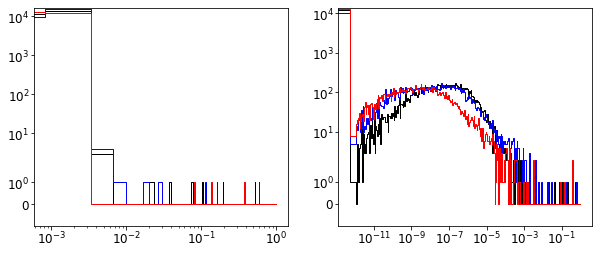

In [18]:
fig,axs=plt.subplots(1,2,figsize=(10,4))
cols = ['black','blue','red']
for i,t in enumerate(evec_ts):
    axs[0].step(load_bin_ctrs_lin, load_hists_lin[t], color=cols[i], where='mid')
    axs[1].step(load_bin_ctrs_log, load_hists_log[t], color=cols[i], where='mid')

axs[0].set_xscale('log')

axs[1].set_xscale('log')
for ax in axs:
    ax.set_yscale('symlog')
    ax.set_ylim(ymin=-1)
    mf.set_axs_fontsize(ax,12)

In [19]:
nbin = 100
gexp_bin_min = np.amin(mu_gexp[mu_gexp>0])
gexp_bin_max = np.amax(mu_gexp[mu_gexp>0])
gexp_bins_lin = np.hstack([[-gexp_bin_min], np.linspace(gexp_bin_min, gexp_bin_max, nbin)])

gexp_bins_log = np.hstack([[-gexp_bin_min], np.logspace(np.log10(gexp_bin_min), np.log10(gexp_bin_max), nbin)])

gexp_hists_log    = np.array([np.histogram(mu_gexp[t], bins=gexp_bins_log)[0] for t in range(nt)])
gexp_bin_ctrs_log = 0.5*(gexp_bins_log[1:]+gexp_bins_log[:-1])

gexp_hists_lin    = np.array([np.histogram(mu_gexp[t], bins=gexp_bins_lin)[0] for t in range(nt)])
gexp_bin_ctrs_lin = 0.5*(gexp_bins_lin[1:]+gexp_bins_lin[:-1])

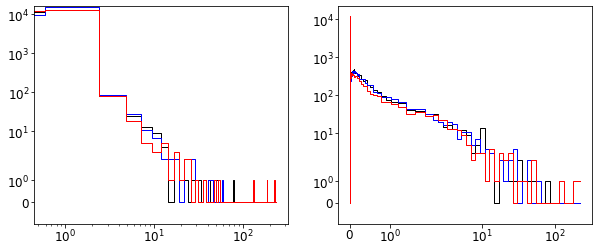

In [20]:
fig,axs=plt.subplots(1,2,figsize=(10,4))
cols = ['black','blue','red']
for i,t in enumerate(evec_ts):
    axs[0].step(gexp_bin_ctrs_lin, gexp_hists_lin[t], color=cols[i], where='mid')
    axs[1].step(gexp_bin_ctrs_log, gexp_hists_log[t], color=cols[i], where='mid')

axs[0].set_xscale('log')

axs[1].set_xscale('symlog')
for ax in axs:
    ax.set_yscale('symlog')
    ax.set_ylim(ymin=-1)
    mf.set_axs_fontsize(ax,12)

In [ ]:
# of genes per cell with expr > 10?

In [21]:
gexp_thresh = 10
hi_mu_gexp_gidxs = [np.where(mu_gexp[t]>gexp_thresh)[0] for t in evec_ts]
hi_mu_gexp_gnm_sets  = [set(gnms[gi]) for gi in hi_mu_gexp_gidxs]
hi_mu_gexp_gnm_dicts = [dict(zip(gnms[gi], mu_gexp[t,gi])) for t, gi in zip(evec_ts, hi_mu_gexp_gidxs)]

load_thresh = 1e-3
hi_load_gidxs = [np.where(pst_pc1_sq[t]>load_thresh)[0] for t in evec_ts]
hi_load_gnm_sets = [set(gnms[gi]) for gi in hi_load_gidxs]
hi_load_gnm_dicts = [dict(zip(gnms[gi], pst_pc1_sq[t,gi])) 
                     for t,gi in zip(evec_ts, hi_load_gidxs)]



In [22]:
for i,t in enumerate(evec_ts):
    print('\nt = {0}\n'.format(t))
    s1 = set(hi_load_gidxs[i])
    s2 = set(hi_mu_gexp_gidxs[i])
    
    isect = list(s1&s2)
    s1_list = list(s1)

    print('# genes with:\n\thi expression = {0}\n\thi evec load = {1}'.format(len(s2), len(s1)))
    print('hi loading, hi expr: {0}'.format([gnms[j] for j in isect]))
    print('hi loading, low expr: {0}'.format([gnms[j] for j in s1-s2]))
    print('\n\tidx\t\tgene\t<expr>\tloading\n')
    
   #srt = np.argsort(-np.array([hi_mu_gexp_gnm_dicts[i][k] for k in isect]))
    srt = np.argsort(-np.array([mu_gexp[evec_ts[i],k] for k in s1_list]))

    for j in range(len(s1_list)):
        gidx = s1_list[srt[j]]
        print('\t{0}\t\t{1}\t{2:.2f}\t{3:.4f}\n'.format(gidx,gnms[gidx],
                                                 mu_gexp[evec_ts[i],gidx],
                                                 pst_pc1_sq[evec_ts[i], gidx]))


t = 0

# genes with:
	hi expression = 21
	hi evec load = 11
hi loading, hi expr: ['mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'Gapdh', 'Rpl23', 'mt-Nd4', 'mt-Atp6', 'mt-Co1', 'mt-Co2']
hi loading, low expr: ['mt-Co3', 'Tuba1b']

	idx		gene	<expr>	loading

	25279		mt-Co2	77.41	0.5266

	25276		mt-Atp6	51.32	0.1946

	25282		mt-Nd1	42.54	0.1070

	25285		mt-Nd4	31.54	0.0741

	25278		mt-Co1	30.36	0.0206

	25281		mt-Cytb	27.05	0.0398

	7941		Gapdh	23.54	0.0040

	19846		Rpl23	19.56	0.0011

	25283		mt-Nd2	13.37	0.0058

	23632		Tuba1b	9.34	0.0035

	25280		mt-Co3	6.91	0.0015


t = 87

# genes with:
	hi expression = 24
	hi evec load = 19
hi loading, hi expr: ['Eef1a1', 'Gapdh', 'Rpl23', 'Srgn', 'Elane', 'Gstm1', 'S100a8', 'S100a9', 'Tuba1b', 'Rps23', 'Ptma', 'mt-Atp6', 'Itm2b', 'mt-Co2']
hi loading, low expr: ['Rps17', 'Rpl27a', 'Mpo', 'Rpl12', 'Rps27a']

	idx		gene	<expr>	loading

	25279		mt-Co2	58.49	0.0020

	25276		mt-Atp6	44.33	0.0060

	21607		Srgn	42.07	0.1166

	7941		Gapdh	27.90	0.0085

	6728		Elane	26.

In [435]:
for i,t in enumerate(evec_ts):
    print('\nt = {0}\n'.format(t))
    s1 = hi_load_gnm_sets[i]
    s2 = hi_mu_gexp_gnm_sets[i]
    
    isect = list(s1&s2)
    print('# genes with:\n\thi expression = {0}\n\thi evec load = {1}'.format(len(s2), len(s1)))
    print('hi loading, hi expr: {0}'.format(isect))
    print('hi loading, low expr: {0}'.format(s1-s2))
    print('\n\tgene\t<expr>\tloading\n')
    
    srt = np.argsort(-np.array([hi_mu_gexp_gnm_dicts[i][k] for k in isect]))
    #srt = np.argsort(-np.array([mu_gexp[evec_ts[i],k] for k in isect]))

    for j in range(len(isect)):
        gnm = isect[srt[j]]
        print('\t{0}\t{1:.2f}\t{2:.4f}\n'.format(gnm,
                                                 hi_mu_gexp_gnm_dicts[i][gnm],
                                                 hi_load_gnm_dicts[i][gnm]))


t = 0

# genes with:
	hi expression = 21
	hi evec load = 11
hi loading, hi expr: ['Gapdh', 'mt-Co1', 'mt-Nd1', 'mt-Co2', 'mt-Cytb', 'mt-Nd2', 'mt-Atp6', 'Rpl23', 'mt-Nd4']
hi loading, low expr: {'mt-Co3', 'Tuba1b'}

	gene	<expr>	loading

	mt-Co2	77.41	0.5266

	mt-Atp6	51.32	0.1946

	mt-Nd1	42.54	0.1070

	mt-Nd4	31.54	0.0741

	mt-Co1	30.36	0.0206

	mt-Cytb	27.05	0.0398

	Gapdh	23.54	0.0040

	Rpl23	19.56	0.0011

	mt-Nd2	13.37	0.0058


t = 87

# genes with:
	hi expression = 24
	hi evec load = 19
hi loading, hi expr: ['Gapdh', 'Gstm1', 'Elane', 'Srgn', 'mt-Co2', 'Rps23', 'S100a8', 'Ptma', 'Eef1a1', 'S100a9', 'mt-Atp6', 'Rpl23', 'Itm2b', 'Tuba1b']
hi loading, low expr: {'Rps27a', 'Rpl12', 'Rpl27a', 'Rps17', 'Mpo'}

	gene	<expr>	loading

	mt-Co2	58.49	0.0020

	mt-Atp6	44.33	0.0060

	Srgn	42.07	0.1166

	Gapdh	27.90	0.0085

	Elane	26.39	0.0290

	S100a9	24.51	0.5946

	Eef1a1	22.57	0.0168

	S100a8	17.81	0.1609

	Rpl23	14.38	0.0019

	Rps23	12.85	0.0036

	Itm2b	11.66	0.0018

	Gstm1	10.52	0.0042



In [23]:
#np.argsort(np.array([hi_mu_gexp_gnm_dicts[k] for k in isect]))

In [24]:
[len(x) for x in hi_mu_gexp_gidxs]

[21, 24, 23]

In [25]:
from matplotlib_venn_wordcloud import venn3_wordcloud
import csv as csv

In [28]:
gexp_full.shape

(130887, 25289)

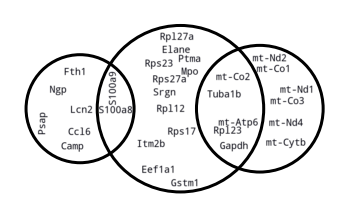

In [29]:
venn3_wordcloud(hi_load_gnm_sets)

In [30]:
#venn3_wordcloud(hi_load_gnm_dicts)

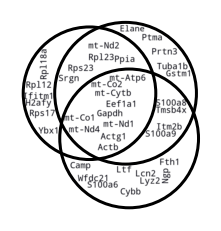

In [31]:
#fig,axs=plt.subplots(figsize=(10,10))
venn3_wordcloud(hi_mu_gexp_gnm_sets)

In [32]:
#venn3_wordcloud(hi_mu_gexp_gnm_dicts)

In [33]:
mgene_fnm = '/Users/simonfreedman/data/bifurc/weinreb_2020/marker_genes.csv'
with open(mgene_fnm) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    mgene_dat = np.array([row for row in csv_reader],dtype='str')
col_names = mgene_dat[0]
mgene_dat = mgene_dat[1:]
mgnm_dict = {}
for ctype,_,gnm,_ in mgene_dat:
    mgnm_dict[ctype] = mgnm_dict.get(ctype,[])+[gnm]

In [35]:
#mgnm_dict

In [36]:
gene_group_labs  = ['neutrophil','MPP','GPP','PMy','My']

neut_gnms        = np.array(['S100a9', 'Itgb2l', 'Elane', 'Fcnb', 'Mpo', 'Prtn3', 
                              'S100a6', 'S100a8', 'Lcn2', 'Lrg1'])
mpp_gnms         = np.array(['Ly6a','Meis1','Flt3','Cd34'])
gmp_gnms         = np.array(['Csf1r','Cebpa'])
pmy_gnms         = np.array(['Gfi1','Elane'])
my_gnms          = np.array(['S100a8','Ngp','Ltf'])

grp_gnms  = [neut_gnms, mpp_gnms, gmp_gnms, pmy_gnms, my_gnms]
grp_gidxs = [np.array([np.where(gnms==gnm)[0][0] for gnm in k]) for k in grp_gnms]

In [37]:
higher_load_gnms  = {evec_ts[1]:['S100a8','S100a9','Srgn'], evec_ts[2]:['Fth1']}
higher_load_gidxs = {k:[np.where(gnms==vi)[0][0] for vi in v] for k,v in higher_load_gnms.items()}

In [546]:
higher_load_gidxs

{87: [20078, 20079, 21607], 109: [7786]}

In [38]:
higher_load_gidxs

{87: [20078, 20079, 21607], 109: [7786]}

In [39]:
gexp_full.shape

(130887, 25289)

In [40]:

ti = 1
t = evec_ts[ti]
gi = 0
#gexp_full[bin_cidxs[t], higher_load_gidxs[t][gi]]

In [41]:
ts    = [k for k,v in higher_load_gidxs.items() for vi in v]
gidxs = [vi for k,v in higher_load_gidxs.items() for vi in v]
gdats = np.array([gexp_full[bin_cidxs[ts[i]], gidxs[i]] for i in range(len(ts))])

In [42]:
gmins = np.array([np.amin(gdat[gdat>0]) for gdat in gdats])
gmaxs = np.amax(gdats, axis=1)
gmaxs = gmaxs + gmins # like adding epsilon..

nbins  = 20
gbins_lin   = np.array([np.hstack([[-gmins[i]],np.linspace(gmins[i],gmaxs[i], nbins)]) for i in range(len(ts))])
gbins_log   = np.array([np.hstack([[-gmins[i]],np.logspace(np.log10(gmins[i]),np.log10(gmaxs[i]), nbins)]) 
                        for i in range(len(ts))])

gbin_ctrs_lin = 0.5*(gbins_lin[:,1:]+gbins_lin[:,:-1])
gbin_ctrs_log = 0.5*(gbins_log[:,1:]+gbins_log[:,:-1])

ghists_lin    = np.array([np.histogram(gdats[i], bins=gbins_lin[i])[0] for i in range(len(ts))])
ghists_log    = np.array([np.histogram(gdats[i], bins=gbins_log[i])[0] for i in range(len(ts))])

#ts, gidxs

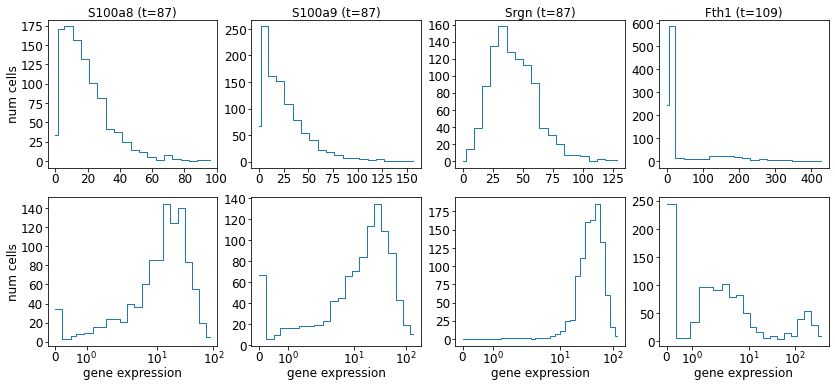

In [501]:
fig,axs=plt.subplots(2,4,figsize=(14,6))

for i,t in enumerate(ts):
    axs[0,i].step(gbin_ctrs_lin[i], ghists_lin[i], where='mid')
    axs[1,i].step(gbin_ctrs_log[i], ghists_log[i], where='mid')

    axs[1,i].set_xscale('symlog')
    #axs[0,i].set_yscale('symlog')
    #axs[1,i].set_yscale('symlog')

    axs[0,i].set_title('{0} (t={1})'.format(gnms[gidxs[i]],ts[i]))
    axs[1,i].set_xlabel('gene expression')

axs[0,0].set_ylabel('num cells')
axs[1,0].set_ylabel('num cells')

for ax in axs:
    for a in ax:
        mf.set_axs_fontsize(a, 12)


In [63]:

#gnorm_sn = np.linalg.norm(gexp_sn,axis=0)
#fth1_ccs = gexp_full[bin_cidxs[evec_ts[2]],gidxs[3]].dot(gexp_full[bin_cidxs[evec_ts[2]],gidxs[3]])/(gnorm_sn)

In [64]:
#gexp_sn.shape, gnorm_sn.shape, fth1_ccs.shape

In [65]:
#fth1_ccs = np.corrcoef(gexp_sn[:,gidxs[3]],gexp_sn.T)

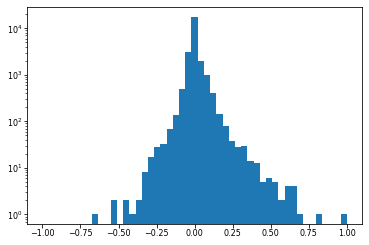

In [68]:
fig,axs=plt.subplots()
axs.hist(fth1_ccs, bins=np.linspace(-1,1,50))
axs.set_yscale('log')

In [159]:
i,int(i/3),2%3

(4, 0, 2)

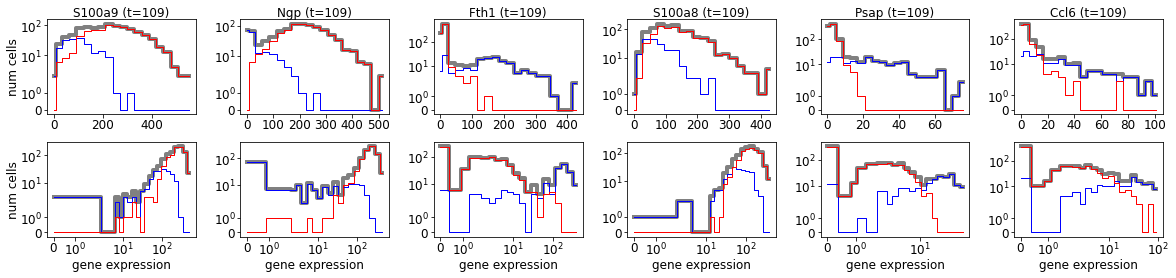

In [550]:
fig,axs=plt.subplots(2,ngs,figsize=(20,4))

branch_cols = ['blue','red']
for i,t in enumerate(gidxs2):
    axs[0,i].step(gbin_ctrs_lin[i], ghists_lin[i], where='mid', color='gray', linewidth=4)
    axs[1,i].step(gbin_ctrs_log[i], ghists_log[i], where='mid', color='gray', linewidth=4)
    
    for j in range(nbranch):
        axs[0,i].step(gbin_ctrs_lin[i], ghists_lin_split[i,j], where='mid', color = branch_cols[j])
        axs[1,i].step(gbin_ctrs_log[i], ghists_log_split[i,j], where='mid', color = branch_cols[j])

    axs[1,i].set_xscale('symlog')
    axs[0,i].set_yscale('symlog')
    axs[1,i].set_yscale('symlog')

    axs[0,i].set_title('{0} (t={1})'.format(gnms[gidxs2[i]],ts[3]))
    axs[1,i].set_xlabel('gene expression')

axs[0,0].set_ylabel('num cells')
axs[1,0].set_ylabel('num cells')

for ax in axs:
    for a in ax:
        mf.set_axs_fontsize(a, 12)
plt.subplots_adjust(hspace=0.3,wspace=0.3)

In [48]:
prices=np.array([76.09,79.25,74.13,74.89,152.64,320.18,384.74,425.35,285.49,268.16,190.02,89.39])
therms = np.array([25.2,26.3,21,22.1,90.4,242.8,331.4,394.1,239.6,215.5,113.4,24.2])
hi_price_mos      = np.where(prices>100)
lo_price_mos      = np.where(prices<=100)
gas_cost_per_year = np.sum(prices[hi_price_mos]-np.mean(prices[lo_price_mos]))

In [65]:
A = np.vstack([therms, np.ones(len(therms))]).T
price_per_therm, min_cost = np.linalg.lstsq(A, prices, rcond=None)[0]

In [66]:
non_heating_month_avg = np.mean(therms[np.where(therms<40)])

In [68]:
heating_therms = np.sum(therms) - non_heating_month_avg*len(therms)

In [71]:
heating_therms*price_per_therm*0.15

212.32776713419602

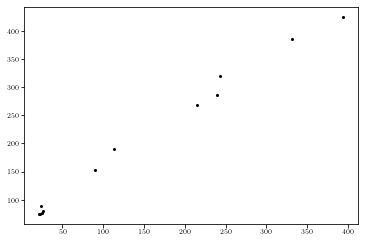

In [55]:
fig,axs=plt.subplots()
axs.plot(therms,prices,'ko')

1475.3300000000002

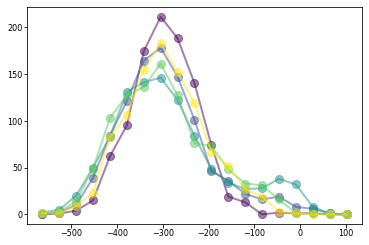

In [557]:
bif_proj_hists.shape

(2, 121, 19)

In [638]:
#gmm_pred_idxs[109]

In [536]:
# nbin = 20
# gexp_bin_min = np.amin(mu_gexp[mu_gexp>0])
# gexp_bin_max = np.amax(mu_gexp[mu_gexp>0])
# gexp_bins_lin = np.hstack([[-gexp_bin_min], np.linspace(gexp_bin_min, gexp_bin_max, nbin)])

# gexp_bins_log = np.hstack([[-gexp_bin_min], np.logspace(np.log10(gexp_bin_min), np.log10(gexp_bin_max), nbin)])

# gexp_hists_log    = np.array([np.histogram(mu_gexp[t], bins=gexp_bins_log)[0] for t in range(nt)])
# gexp_bin_ctrs_log = 0.5*(gexp_bins_log[1:]+gexp_bins_log[:-1])

# gexp_hists_lin    = np.array([np.histogram(mu_gexp[t], bins=gexp_bins_lin)[0] for t in range(nt)])
# gexp_bin_ctrs_lin = 0.5*(gexp_bins_lin[1:]+gexp_bins_lin[:-1])

# ghists_lin = np.histogram(gexp_full[bin_cidxs[t],higher_load_gidxs[t][i]]) 

In [47]:

# # Opening JSON file
# f = open('data.json')
  
# # returns JSON object as 
# # a dictionary
# data = json.load(f)

In [151]:
proc_gct_all = [{},{},{}]
proc_gct     = [{},{},{}] # only those that are in our list of genes
nlev = 3
gnm_set = set(gnms) 
for i in range(nlev):
    for proc, p_gnms in proc_gnms[i].items():
        proc_gct_all[i][proc] = len(p_gnms)
        proc_gct[i][proc] = len(set(p_gnms) & gnm_set)

In [153]:
proc_gct[0]

{9100: 1664,
 9120: 1213,
 9130: 2328,
 9140: 1657,
 9150: 3878,
 9160: 3124,
 9180: 12850,
 9190: 662}

In [50]:
from collections import Counter

In [69]:
ngs = 20
gidxs3 = np.argsort(-np.abs(fth1_ccs))[0:ngs]
g3_proc_ct = np.array([[k,v] for k,v in 
                       Counter(np.hstack([gnm_ko[g][0] for g in gnms[gidxs3] if g in gnm_ko])).items()])
g3_proc_ct = g3_proc_ct[np.argsort(-g3_proc_ct[:,1])]

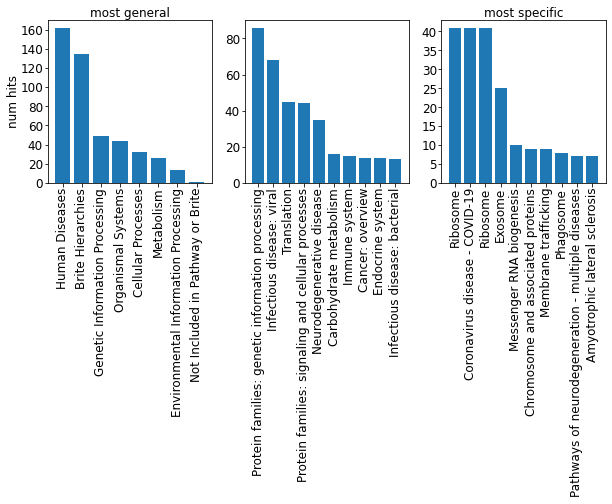

In [111]:
ngs      = 100
max_nbar = 10
gidxs    = np.argsort(-pst_pc1_sq[evec_ts[1]])[0:ngs]
fig,axs  = plt.subplots(1,3,figsize=(10,3))
for i in range(3):
    proc_ct = np.array([[k,v] for k,v in 
                    Counter(np.hstack([gnm_ko[g][i] 
                                       for g in gnms[gidxs] if g in gnm_ko])).items()])
    proc_ct = proc_ct[np.argsort(-proc_ct[:,1])]
    
    nbar = min(len(proc_ct), max_nbar)
    axs[i].bar(np.arange(nbar), proc_ct[0:nbar,1])
    
    bar_names = [ko_id_def[i][j] for j in proc_ct[:nbar,0]]
    bar_names = [x.split('[',1)[0].rstrip() for x in bar_names]
    axs[i].set_xticks(np.arange(nbar))
    axs[i].set_xticklabels(bar_names, rotation=90)
    

axs[0].set_ylabel('num hits')
axs[0].set_title('most general')
axs[2].set_title('most specific')

for ax in axs:
    mf.set_axs_fontsize(ax,12)
    #print(bar_names)
    #{ko_id_def[0][i[0]]:i[1] for i in g3_proc_ct}
    #axs[i].

In [287]:
top_proc_idxs_flat[i]

array([41, 48, 49, 37, 38, 25, 35, 21, 28, 19])

In [311]:
np.argsort(np.sum(top_wts,axis=1))

array([ 2,  1,  3,  4,  0,  8, 10,  6,  7,  9,  5])

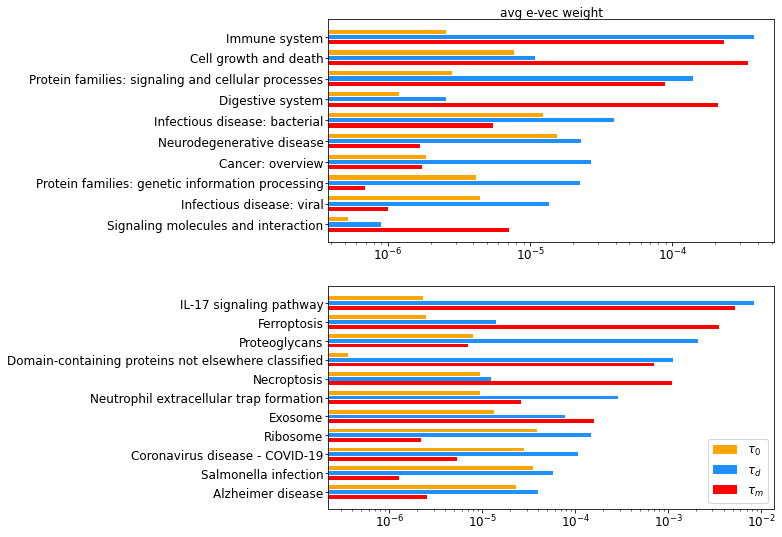

In [313]:
fig,axs  = plt.subplots(2,1,figsize=(8,9))
yoff = [0.25,0,-0.25]
bcol = ['orange','dodgerblue','red']
labs = [r'$\tau_0$', r'$\tau_d$',r'$\tau_m$']
for i in range(1,nproc_lev):
    axi      = i - 1
    
    top_wts  = proc_wts_norm[i][top_proc_idxs_flat[i]]
    proc_ord = np.argsort(np.sum(top_wts,axis=1))
    
    nbar     = top_wts.shape[0]
    
    for ti in range(len(evec_ts)):
        axs[axi].barh(np.arange(nbar)+yoff[ti], top_wts[proc_ord,ti], color = bcol[ti], height=0.2, log=True, 
                      label=labs[ti])
    
    bar_names = [ko_id_def[i][kidx2ko_id[i][j]] for j in top_proc_idxs_flat[i]]
    bar_names = np.array([x.split('[',1)[0].rstrip() for x in bar_names])
    axs[axi].set_yticks(np.arange(nbar))
    axs[axi].set_yticklabels(bar_names[proc_ord])#, rotation=90)
    
    
axs[0].set_title('avg e-vec weight')
axs[1].legend(fontsize=fs)

for ax in axs:
    mf.set_axs_fontsize(ax,fs)

In [274]:
#[np.argsort(-proc_wts[i][:,ti])[0:nproc] for ti in range(len(evec_ts))]

In [260]:
#proc_wts[0]

In [ ]:
np.unique([])

In [261]:
#pst_pc1_sq.shape

In [213]:
#proc_norms = [np.array([proc_gct[i][x] for x in proc_wts_arr[i][:,0]]) for i in range(nlev)]

In [214]:
#proc_gct[2]

In [215]:
#proc_gct_all[0]

In [216]:
#mmm = proc_wts_arr[2][:,[0,2]]
#mmm[np.where(mmm[:,0]==1040)]

G = number of genes in transcriptome
P1 = number of genes involved in signaling system
P2 = number of genes involved in signaling system that are also in G

proc_wts_arr[i][:,2] is the number of times a KEGG category is mapped to by a gene in the transcriptome
                      so a single gene can map to category A twice, if it is involved in two subcategories 
                      (A1 and A2)
proc_gct[i] is the number of genes in the transcriptome that are also in the KEGG category, 
             so a single gene WILL NOT be mapped twice, even if two subcategories are involved
             
proc_wts_arr and proc_gct should be equivalent for i=2

In [217]:
# sort_by_c1 = lambda a: a[np.argsort(a[:,0])]
# x1=sort_by_c1(np.array([[k,v] for k,v in proc_gct[2].items()]))
# x2=sort_by_c1(proc_wts_arr[2][:,[0,2]])

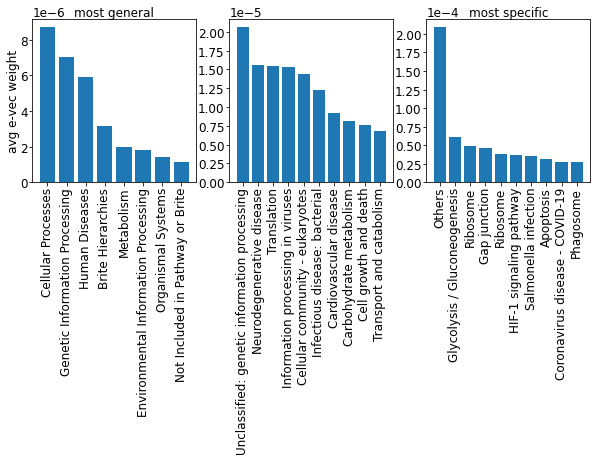

In [221]:
max_nbar = 10
fs = 12
fig,axs  = plt.subplots(1,3,figsize=(10,3))
for i in range(nproc_lev):
    proc_wts = np.copy(proc_wts_arr[i])
    proc_wts[:,1] = proc_wts[:,1]/proc_wts[:,2]
    #proc_wts[:,1] = proc_wts[:,1]/proc_norms[i]

    proc_wts = proc_wts[np.argsort(-proc_wts[:,1])]
    
    nbar = min(proc_wts.shape[0], max_nbar)
    axs[i].bar(np.arange(nbar), proc_wts[0:nbar,1])
    
    bar_names = [ko_id_def[i][j] for j in proc_wts[:nbar,0]]
    bar_names = [x.split('[',1)[0].rstrip() for x in bar_names]
    axs[i].set_xticks(np.arange(nbar))
    axs[i].set_xticklabels(bar_names, rotation=90)
    axs[i].ticklabel_format(axis='y',style='sci',scilimits=(0,5))
    axs[i].yaxis.get_offset_text().set_fontsize(fs)

    
axs[0].set_ylabel('avg e-vec weight')
axs[0].set_title('most general')
axs[2].set_title('most specific')

for ax in axs:
    mf.set_axs_fontsize(ax,fs)
    
#plt.subplots_adjust(wspace=)

In [125]:
pst_pc1_sq.shape

(121, 25289)

In [123]:
proc_wts

[{9180: array([8.89150319e-33, 4.26389755e-07, 1.31283338e-06, ...,
         9.49166624e-06, 1.28356502e-03, 6.31737997e-07])},
 {9182: array([8.89148778e-33, 4.24434043e-07, 1.29775925e-06, ...,
         6.00794795e-06, 9.70967720e-04, 5.27969184e-07]),
  9183: array([1.54084587e-38, 1.95571240e-09, 1.50741306e-08, ...,
         3.48371829e-06, 3.12597299e-04, 1.03768813e-07])},
 {4131: array([1.62112486e-39, 2.06580726e-08, 1.12913336e-08, ...,
         2.04146645e-06, 3.99572028e-04, 2.60548559e-07]),
  3036: array([1.53689100e-46, 9.60745145e-08, 1.25152200e-06, ...,
         2.83471273e-06, 6.27914727e-06, 2.15630446e-07]),
  4812: array([1.54084587e-38, 1.95571240e-09, 1.50741306e-08, ...,
         3.48371829e-06, 3.12597299e-04, 1.03768813e-07]),
  3029: array([8.89148616e-33, 3.07701456e-07, 3.49459151e-08, ...,
         1.13176876e-06, 5.65116545e-04, 5.17901793e-08])}]

In [121]:
proc_wts[2].keys()

dict_keys([4131, 3036, 4812, 3029])

In [101]:
[x.split('[',1)[0].rstrip() for x in bar_names]

['Exosome',
 'Membrane trafficking',
 'Ferroptosis',
 'Necroptosis',
 'Lysosome',
 'Peptidases and inhibitors',
 'Autophagy - animal',
 'Pathways of neurodegeneration - multiple diseases',
 'Diabetic cardiomyopathy',
 'Phagosome']

In [99]:
#proc_ct
[ko_id_def[0][i] for i in g3_proc_ct[:,0]]

['Human Diseases',
 'Brite Hierarchies',
 'Cellular Processes',
 'Organismal Systems',
 'Metabolism',
 'Environmental Information Processing']

In [85]:
{ko_id_def[0][i[0]]:i[1] for i in g3_proc_ct}

{'Human Diseases': 33,
 'Brite Hierarchies': 29,
 'Cellular Processes': 20,
 'Organismal Systems': 14,
 'Metabolism': 5,
 'Environmental Information Processing': 5}

In [48]:
[mmu_ko['children'][i]['name'] for i in range(len(mmu_ko['children']))]

['09100 Metabolism',
 '09120 Genetic Information Processing',
 '09130 Environmental Information Processing',
 '09140 Cellular Processes',
 '09150 Organismal Systems',
 '09160 Human Diseases',
 '09180 Brite Hierarchies',
 '09190 Not Included in Pathway or Brite']

In [602]:
[[[mmu_ko['children'][i]['children'][j]['children'][k]['name'] 
  for k in range(len(mmu_ko['children'][i]['children'][j]['children']))]
  for j in range(len(mmu_ko['children'][i]['children']))]
 for i in range(len(mmu_ko['children']))]

[[['00010 Glycolysis / Gluconeogenesis [PATH:mmu00010]',
   '00020 Citrate cycle (TCA cycle) [PATH:mmu00020]',
   '00030 Pentose phosphate pathway [PATH:mmu00030]',
   '00040 Pentose and glucuronate interconversions [PATH:mmu00040]',
   '00051 Fructose and mannose metabolism [PATH:mmu00051]',
   '00052 Galactose metabolism [PATH:mmu00052]',
   '00053 Ascorbate and aldarate metabolism [PATH:mmu00053]',
   '00500 Starch and sucrose metabolism [PATH:mmu00500]',
   '00520 Amino sugar and nucleotide sugar metabolism [PATH:mmu00520]',
   '00620 Pyruvate metabolism [PATH:mmu00620]',
   '00630 Glyoxylate and dicarboxylate metabolism [PATH:mmu00630]',
   '00640 Propanoate metabolism [PATH:mmu00640]',
   '00650 Butanoate metabolism [PATH:mmu00650]',
   '00660 C5-Branched dibasic acid metabolism',
   '00562 Inositol phosphate metabolism [PATH:mmu00562]'],
  ['00190 Oxidative phosphorylation [PATH:mmu00190]',
   '00195 Photosynthesis',
   '00196 Photosynthesis - antenna proteins',
   '00710 Carbon

In [650]:
i=0
j=0
k=0
l=10
mmu_ko['children'][i]['children'][j]['children'][k]['children'][l]['name']# .split(';')[0]

'14120 Fbp2; fructose bisphosphatase 2\tK03841 FBP; fructose-1,6-bisphosphatase I [EC:3.1.3.11]'

In [653]:
np.sort(list(gnm_ko.keys()))

array(['0610009B22Rik', '0610010K14Rik', '1110017D15Rik', ..., 'n-R5s146',
       'n-R5s149', 'sp110'], dtype='<U17')

In [687]:
[x.split(' ',1) for x in gnm_ko['Hk2'][0]]

[['09100', 'Metabolism'],
 ['09100', 'Metabolism'],
 ['09100', 'Metabolism'],
 ['09100', 'Metabolism'],
 ['09100', 'Metabolism'],
 ['09100', 'Metabolism'],
 ['09130', 'Environmental Information Processing'],
 ['09150', 'Organismal Systems'],
 ['09150', 'Organismal Systems'],
 ['09160', 'Human Diseases'],
 ['09160', 'Human Diseases'],
 ['09180', 'Brite Hierarchies']]

In [680]:
np.where(gnms=='Fbp')

(array([], dtype=int64),)

In [660]:
txt = "The rain in Spain"
blnk=''
x = re.search("^The.*Spain$", txt)
y = re.search("^The.*Spain$", blnk)



In [669]:
x = re.search("[Rr]ain", '')


In [670]:
x

In [673]:
res = [gnm for gnm in list(gnm_ko.keys()) if re.search('[Nn]gp', gnm) is not None]

In [674]:
res

['Angpt1',
 'Angpt2',
 'Angpt4',
 'Angptl4',
 'Angptl3',
 'Angptl8',
 'Angptl1',
 'Angptl7',
 'Angptl2',
 'Angptl6']

In [678]:
np.where(gnms=='Angpt2')

(array([2584]),)

In [607]:
np.where(gnms=='Hk2')

(array([12258]),)

In [710]:
gnm_ko['S100a8']

[[9150, 9180], [9151, 9183], [4657, 4990]]

In [632]:
n_annot = np.array([len(v[0]) for k,v in gnm_ko.items()])
ko_idx2gnm = {i:k for i,k in zip(range(len(gnm_ko)), gnm_ko)}

In [630]:
np.max(n_annot)

118

In [631]:
np.argmax(n_annot)

3281

In [633]:
ko_idx2gnm[3281]

'Mapk1'

array([[4216,    3],
       [4217,    3],
       [4978,    1],
       [4147,    9],
       [ 600,    1],
       [4142,    3],
       [4625,    1],
       [4054,    1],
       [4090,    2],
       [4091,    1],
       [ 480,    1],
       [ 980,    1],
       [ 982,    1],
       [ 983,    1],
       [5200,    1],
       [5204,    1],
       [5207,    1],
       [5208,    1],
       [5225,    1],
       [5418,    2],
       [1524,    1],
       [2000,    2],
       [4131,    5],
       [4140,    3],
       [4210,    2],
       [4621,    2],
       [4612,    2],
       [4924,    1],
       [1002,    3],
       [3110,    1],
       [ 536,    1],
       [4060,    1],
       [4061,    1],
       [4062,    1],
       [4052,    1],
       [4071,    1],
       [4915,    1],
       [5152,    1],
       [5415,    2],
       [4640,    1],
       [3037,    1],
       [4137,    1],
       [4218,    2],
       [4380,    1],
       [5014,    1],
       [5022,    2],
       [3029,    1],
       [4066,

In [ ]:
gnm_ko

In [625]:
list(map(len,gnm_ko['Hk2']))

[12, 12, 12]

In [616]:
len(np.intersect1d(list(gnm_ko.keys()), gnms))

15243

In [731]:
hi_load_gnm_sets
proc_dicts = []
for i,gset in enumerate(hi_load_gnm_sets):
    proc_dicts.append([])
    for j in range(3):
        proc_list = np.hstack([gnm_ko[g][j] for g in gset if g in gnm_ko])
        proc_ct = np.array([[k,v] for k,v in Counter(proc_list).items()])
        proc_ct = proc_ct[np.argsort(-proc_ct[:,1])]
        proc_dicts[i].append({ko_id_def[j][k[0]]:k[1] for k in proc_ct})

In [735]:
proc_dicts[2]

[{'Organismal Systems': 8,
  'Brite Hierarchies': 5,
  'Cellular Processes': 3,
  'Environmental Information Processing': 2,
  'Human Diseases': 2,
  'Metabolism': 1},
 {'Immune system': 6,
  'Protein families: signaling and cellular processes': 5,
  'Signaling molecules and interaction': 2,
  'Cell growth and death': 2,
  'Digestive system': 2,
  'Infectious disease: bacterial': 2,
  'Lipid metabolism': 1,
  'Transport and catabolism': 1},
 {'IL-17 signaling pathway [PATH:mmu04657]': 3,
  'Exosome [BR:mmu04147]': 2,
  'Domain-containing proteins not elsewhere classified [BR:mmu04990]': 2,
  'Sphingolipid metabolism [PATH:mmu00600]': 1,
  'Salivary secretion [PATH:mmu04970]': 1,
  'NOD-like receptor signaling pathway [PATH:mmu04621]': 1,
  'Neutrophil extracellular trap formation [PATH:mmu04613]': 1,
  'Mineral absorption [PATH:mmu04978]': 1,
  'Necroptosis [PATH:mmu04217]': 1,
  'Ferroptosis [PATH:mmu04216]': 1,
  'Cytokines and growth factors [BR:mmu04052]': 1,
  'Chemokine signaling

In [413]:
PCA(n_components=1).fit(gexp_full[bin_cidxs[t]][:,gmm_pred_idxs[t][i]]).explained_variance_

array([4.50981587])

In [429]:
t=0
i=0
gexp_full[bin_cidxs[t][gmm_pred_idxs[t][i]]].shape

(1000, 25289)

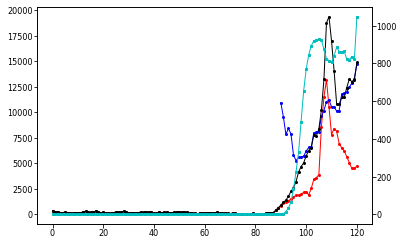

In [432]:
fig,axs=plt.subplots()
axs.plot(gmm_cov_eval[:,0]-np.amin(gmm_cov_eval[:,0]),'ro-')
axs.plot(gmm_cov_eval[:,1],'bo-')
axs.plot(pst_eig1 - np.amin(pst_eig1),'ko-')
ax2 = axs.twinx()
ax2.plot(nc1,'cs-')


In [425]:
nc1

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    3,    4,   14,   34,   64,  134,  225,  329,  491,
        654,  769,  845,  893,  920,  923,  928,  924,  875,  824,  815,
        805,  839,  886,  862,  862,  864,  822,  820,  836,  823, 1047])